<img src="img/logo.png">

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mylib.fonction_exploration import exploration1, exploration2, exploration3, exploration4
from mylib.fonction_pk import test_pk
from mylib.fonction_merge import df_merge
from mylib.fonction_acp import display_circles, display_factorial_planes, display_scree_plot
import mylib.fonction_clustering as fonction_clustering
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import seaborn as sns
from pandas_profiling import ProfileReport
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display_html 
from sklearn.cluster import KMeans
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
#from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
#pip install kneed
from kneed import KneeLocator
#!pip install gap-stat
from gap_statistic import OptimalK

print("Version numpy : " + np.__version__)
print("Version pandas : " + pd.__version__)

bold = "\033[1m"
red = "\033[31m"
end = "\033[0;0m"

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "111%"),
                              ("color", 'black')])]

chemin1 = 'src/p9_2019_cleaned.xlsx'
chemin2 = 'src/p9_log_2019_cleaned.xlsx'

Version numpy : 1.23.5
Version pandas : 1.4.4


# Loading the cleaned files

In [2]:
p9 = pd.read_excel(chemin1)
p9_log = pd.read_excel(chemin2)
p9_log = p9_log.set_index('Country')

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Clustering with PCA vs. without PCA

## Without PCA

<img src="img/Clustering without PCA.png">

## With PCA

<img src="img/Clustering with PCA.png">

<span style="color:red">**=> Au vu du clustering avant ACP de moindre qualité, je choisis dans la suite de notre étude d'effectuer le clustering après ACP**</span>

# Principal Component Analysis

In [4]:
# import de l'échantillon et des informations
data = p9_log

# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# ACP
pca = decomposition.PCA().fit(X_scaled)
X_projected = pca.transform(X_scaled)

## Variances cumulative sum

In [6]:
# création d'un DataFrame résumant la variance
pd.DataFrame({"Dimension" : [f"Dim{i+1}" for i in range(len(pca.explained_variance_ratio_.cumsum()))],
              "Variance (%)" : np.round(pca.explained_variance_ratio_ * 100, 2),
             "Cumulative variance (%)" : np.round(pca.explained_variance_ratio_.cumsum() * 100, 2)})

Dimension  Variance (%)  Cumulative variance (%)
0       Dim1         33.52                    33.52
1       Dim2         19.85                    53.37
2       Dim3          9.95                    63.31
3       Dim4          7.11                    70.42
4       Dim5          5.63                    76.05
5       Dim6          4.88                    80.94
6       Dim7          3.84                    84.77
7       Dim8          3.28                    88.05
8       Dim9          2.67                    90.72
9      Dim10          2.60                    93.31
10     Dim11          2.32                    95.63
11     Dim12          1.53                    97.17
12     Dim13          1.18                    98.35
13     Dim14          0.96                    99.31
14     Dim15          0.48                    99.79
15     Dim16          0.14                    99.93
16     Dim17          0.07                   100.00

### Kaiser rule

In [7]:
# critère de Kaiser
p = len(p9_log.columns)
kaiser = 100 / p
print("Variability of an initial feature :", round(kaiser,2), "%")

Variability of an initial feature : 5.88 %


<span style="color:red">**=> Les 4 premières composantes (deux premiers plans factoriels F1/F2 et F3/F4) representent 70% de l'information**</span>

<span style="color:red">**=> Nous ne prendrons pas en compte les composantes suivantes car selon le critère de Kaiser, elles représentent moins de variabilité qu’une variable initiale (inf. à 5,88%)**</span>

## PCA with 4 components

In [8]:
# choix du nombre de composantes à calculer
n_comp = 4

# import de l'échantillon
data = p9_log

# préparation des données pour l'ACP
X = data.values
names = data.index
features = data.columns

# centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
#pca.fit(X_scaled)
X_projected = pca.fit_transform(X_scaled)

In [9]:
# création d'un DataFrame résumant la variance des 4 premières composantes
pd.DataFrame({"Dimension" : [f"Dim{i+1}" for i in range(4)],
              "Variance (%)" : np.round(pca.explained_variance_ratio_ * 100, 2),
             "Cumulative variance (%)" : np.round(pca.explained_variance_ratio_.cumsum() * 100, 2)})

Dimension  Variance (%)  Cumulative variance (%)
0      Dim1         33.52                    33.52
1      Dim2         19.85                    53.37
2      Dim3          9.95                    63.31
3      Dim4          7.11                    70.42

In [10]:
#pca.components_
x_list = range(1, n_comp+1)
list(x_list)

[1, 2, 3, 4]

In [11]:
# création d'un DataFrame avec les caractéristiques des 4 premières composantes
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs = pcs.round(2).T
pcs

F1    F2    F3    F4
Population                              -0.00 -0.45  0.34 -0.09
Under-nourishment (%)                    0.36  0.01 -0.02 -0.01
HDI                                     -0.38  0.11  0.11 -0.04
Peace_index                              0.23 -0.22  0.17 -0.06
Vegetables disponibility (kg/cap/year)  -0.05 -0.28 -0.47 -0.38
Enough veg intake (> 91.25 kg/cap/year) -0.12 -0.15 -0.45 -0.49
Production                              -0.07 -0.52  0.07 -0.02
Exportations                            -0.22 -0.30  0.15  0.14
Importations                            -0.27 -0.19  0.43 -0.27
Customs duration (h)                     0.32 -0.06  0.11 -0.17
Customs tax (%)                          0.30 -0.15  0.06  0.05
Distance (km)                            0.24 -0.07  0.17  0.00
Gdp/cap                                 -0.37  0.12  0.16 -0.06
Population evolution (4y, %)             0.31 -0.06  0.01 -0.15
Trade balance (exp-imp)                 -0.06 -0.24 -0.25  0.61
Self-sufficiency (prod-dispo)           -0.10 -0.37 -0.27  0.29
Market growth (2y, %)                   -0.16 -0.00 -0.03 -0.05

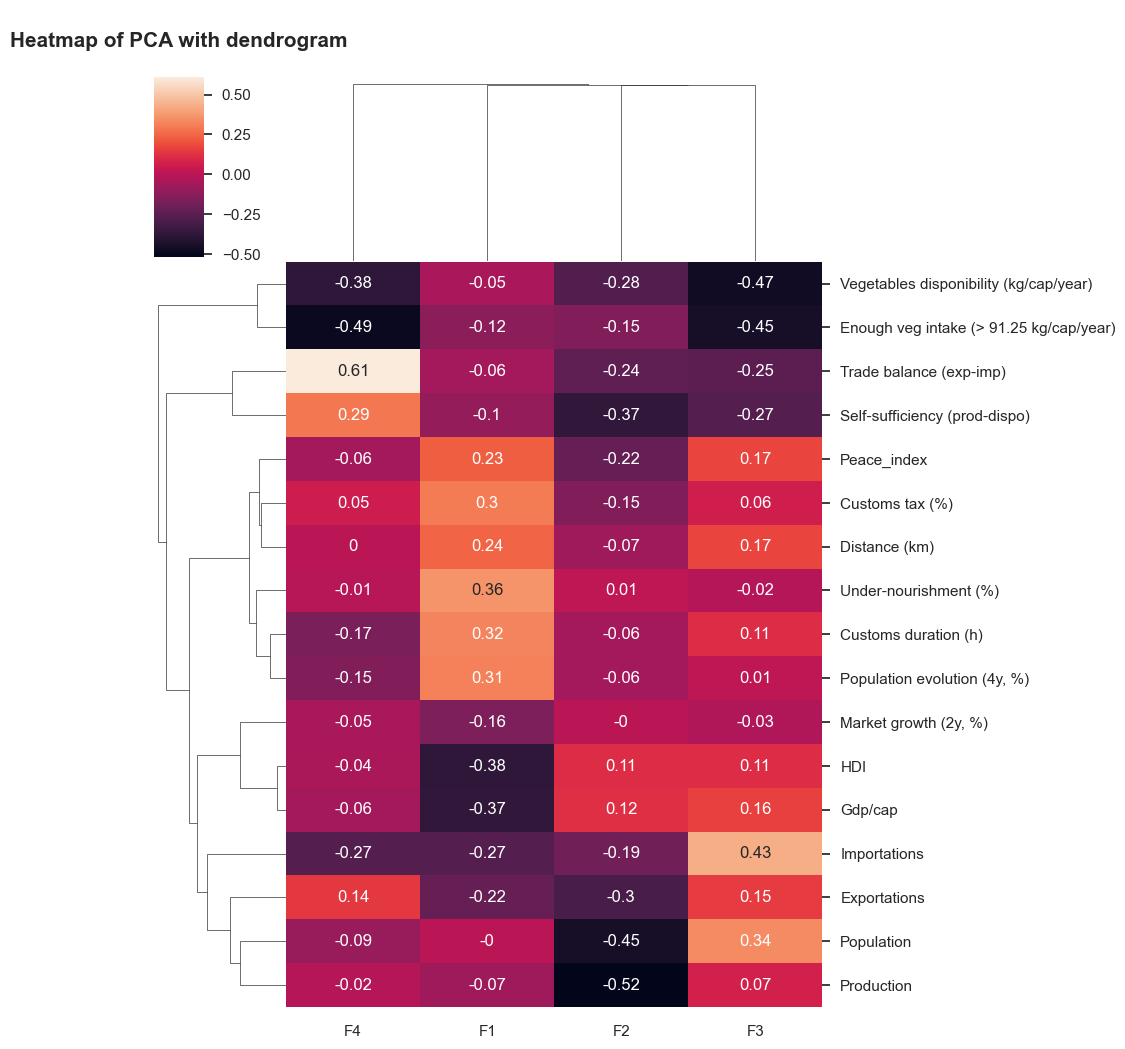

In [12]:
# visualisation heatmap avec dendrogramme
#fig = plt.figure(figsize=(15,12))
sns.set(font_scale=1)
sns.clustermap(pcs, annot=True)
plt.title('\nHeatmap of PCA with dendrogram\n', fontsize=15, fontweight='bold')
plt.savefig('img/saved/pca_heatmap.jpeg');

## Visualization of the PCA

Populating the interactive namespace from numpy and matplotlib


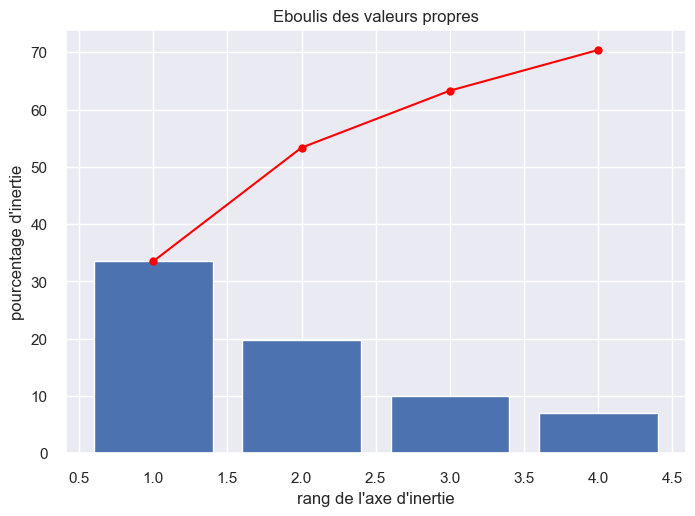

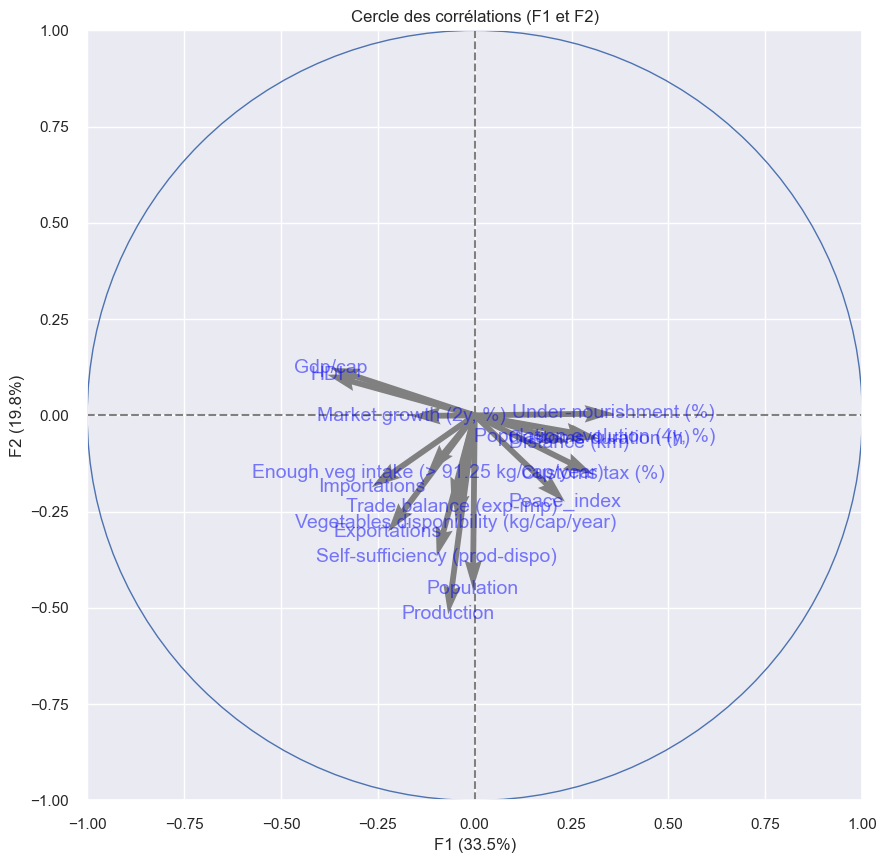

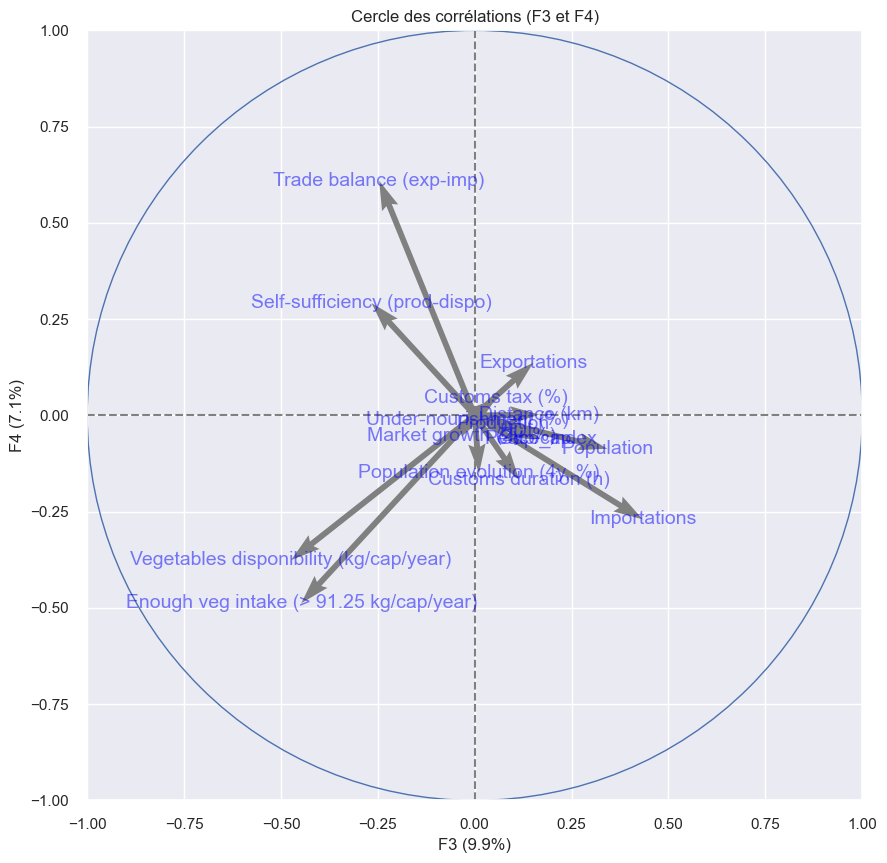

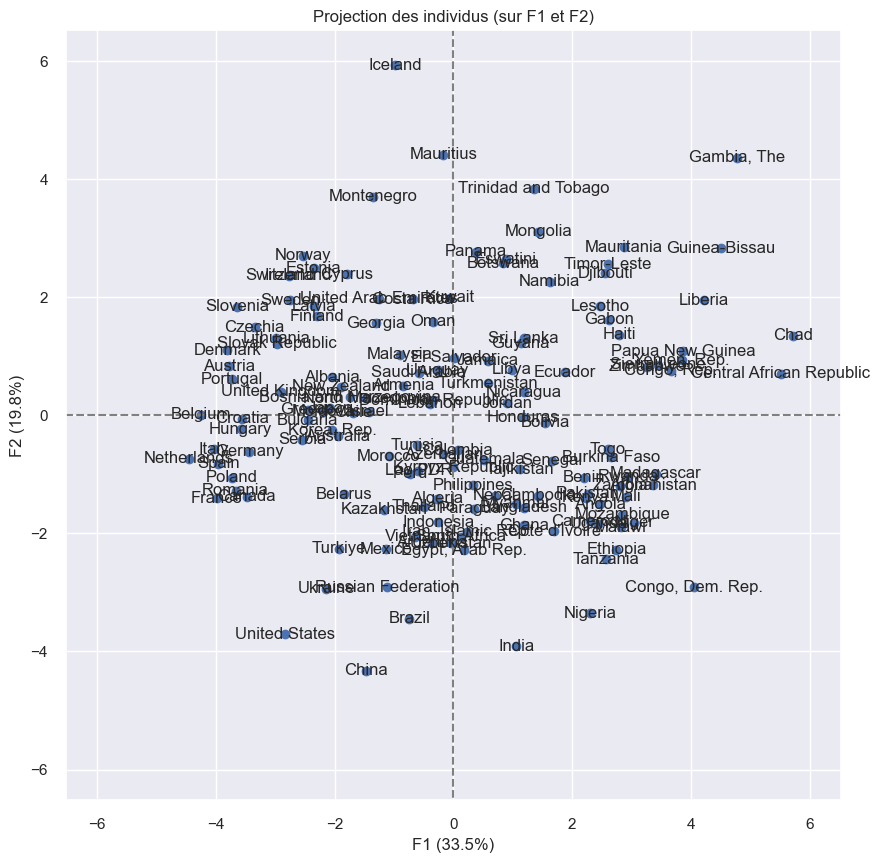

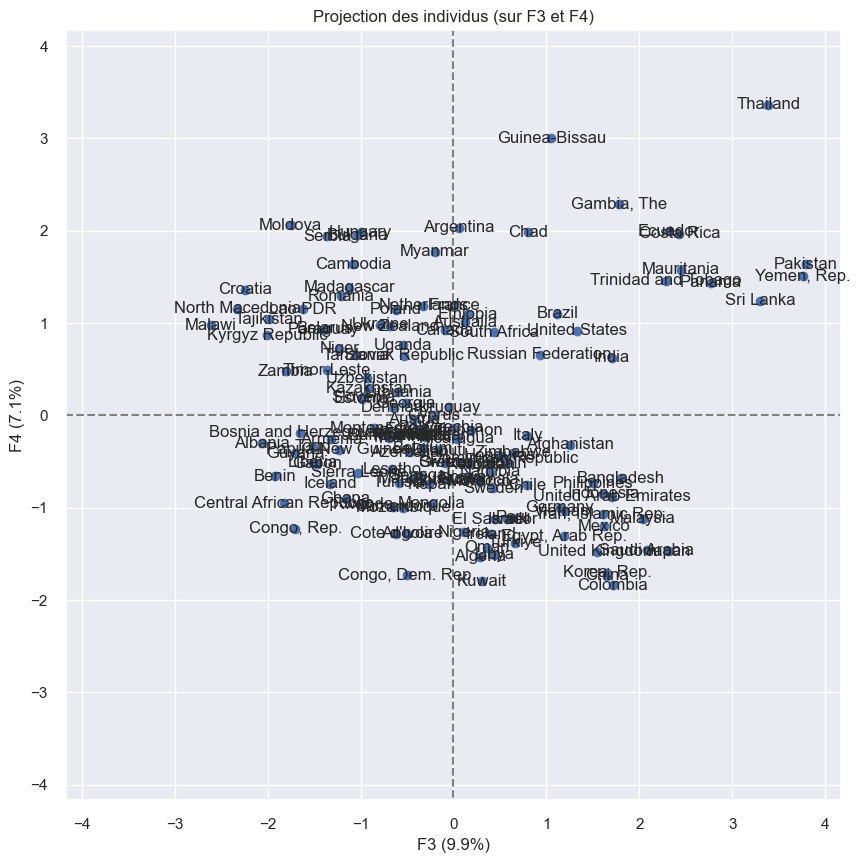

In [13]:
# visualisation
# éboulis des valeurs propres
%pylab inline
display_scree_plot(pca)

# cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

# projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], 
                         #illustrative_var = clusters, 
                         labels = np.array(names))
plt.show()

# **HCA - KMeans**

## HCA

### Defining the optimal number of clusters

#### Silhouette, Davies-Bouldin, Calinski-Harabasz

In [14]:
# définition de DataFrame vide
df_metrics_cah = pd.DataFrame()

In [15]:
# tuning des hyperparamètres n_clusters, linkage, affinity
n_clusters = range(3, 9)
linkages = ['complete', 'average', 'single']
affinity = ['euclidean', 'manhattan', 'cosine']
param_grid_cah = [n_clusters, linkages, affinity]

df_metrics_cah = fonction_clustering.calcul_metrics_cah(X_projected,
                                           df_metrics_cah,
                                           'CAH log PCA', seed,
                                           param_grid_cah)
#df_metrics_cah.style.hide_index()

In [16]:
# tuning des hyperparamètres n_clusters, linkage, affinity
n_clusters = range(3, 9)
linkages = ['ward']
affinity = ['euclidean']
param_grid_cah_ward = [n_clusters, linkages, affinity]

df_metrics_cah = \
    fonction_clustering.calcul_metrics_cah(X_projected,
                                           df_metrics_cah,
                                           'CAH log PCA', seed,
                                           param_grid_cah_ward)
#df_metrics_cah.style.hide_index()

In [17]:
# coéfficient de silhouette : le plus proche de 1
df_metrics_cah.sort_values(by='silhouette', ascending=False).head(5)

data type  n_clusters   linkage   affinity  silhouette  davies_bouldin  \
54  CAH log PCA           3      ward  euclidean        0.28            1.16   
10  CAH log PCA           4  complete  manhattan        0.26            1.27   
5   CAH log PCA           3   average     cosine        0.26            1.41   
12  CAH log PCA           4   average  euclidean        0.26            1.03   
13  CAH log PCA           4   average  manhattan        0.26            1.00   

    calinski_harabasz  
54              45.85  
10              54.34  
5               52.42  
12              38.75  
13              32.51

In [18]:
# indice de Davies-Bouldin : le plus proche de 0
df_metrics_cah.sort_values(by='davies_bouldin').head(5)

data type  n_clusters linkage   affinity  silhouette  davies_bouldin  \
7   CAH log PCA           3  single  manhattan        0.20            0.67   
51  CAH log PCA           8  single  euclidean        0.07            0.69   
52  CAH log PCA           8  single  manhattan        0.05            0.69   
42  CAH log PCA           7  single  euclidean        0.12            0.70   
43  CAH log PCA           7  single  manhattan        0.12            0.70   

    calinski_harabasz  
7                6.70  
51               4.89  
52               4.80  
42               5.23  
43               5.23

In [19]:
# score de Calinski-Harabasz : le plus grand possible
df_metrics_cah.sort_values(by='calinski_harabasz', ascending=False).head(5)

data type  n_clusters   linkage   affinity  silhouette  davies_bouldin  \
10  CAH log PCA           4  complete  manhattan        0.26            1.27   
14  CAH log PCA           4   average     cosine        0.25            1.28   
23  CAH log PCA           5   average     cosine        0.25            1.11   
5   CAH log PCA           3   average     cosine        0.26            1.41   
2   CAH log PCA           3  complete     cosine        0.22            1.46   

    calinski_harabasz  
10              54.34  
14              53.78  
23              53.40  
5               52.42  
2               48.25

**Conclusion :**
- Silhouette : 3 clusters, ward, euclidean or 4 complete, manhattan
- Davies-Bouldin : 3 clusters, single, manhattan
- Calinski-Harabasz : 4 clusters, complete, manhattan

In [20]:
# création de DataFrame pour faciliter la visualisation en utilisant les meilleurs scores Silhouette et Calinski-Harabasz
df_cah = df_metrics_cah[(df_metrics_cah['affinity'] == 'manhattan') & (df_metrics_cah['linkage'] == 'complete')]
df_cah

data type  n_clusters   linkage   affinity  silhouette  davies_bouldin  \
1   CAH log PCA           3  complete  manhattan        0.10            2.59   
10  CAH log PCA           4  complete  manhattan        0.26            1.27   
19  CAH log PCA           5  complete  manhattan        0.25            1.13   
28  CAH log PCA           6  complete  manhattan        0.25            1.13   
37  CAH log PCA           7  complete  manhattan        0.25            1.05   
46  CAH log PCA           8  complete  manhattan        0.25            1.01   

    calinski_harabasz  
1               16.81  
10              54.34  
19              46.69  
28              44.17  
37              43.57  
46              40.66

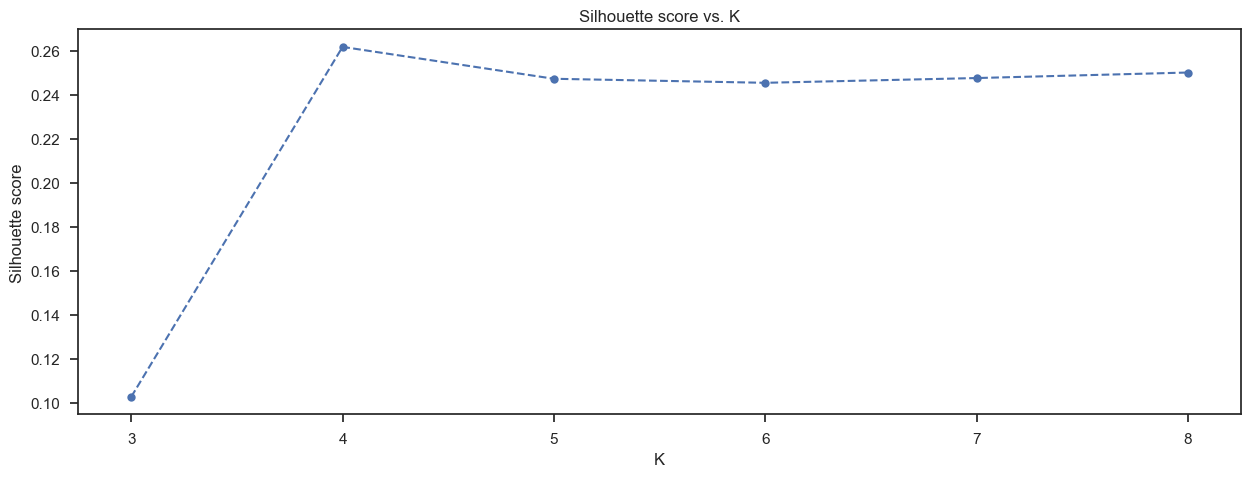

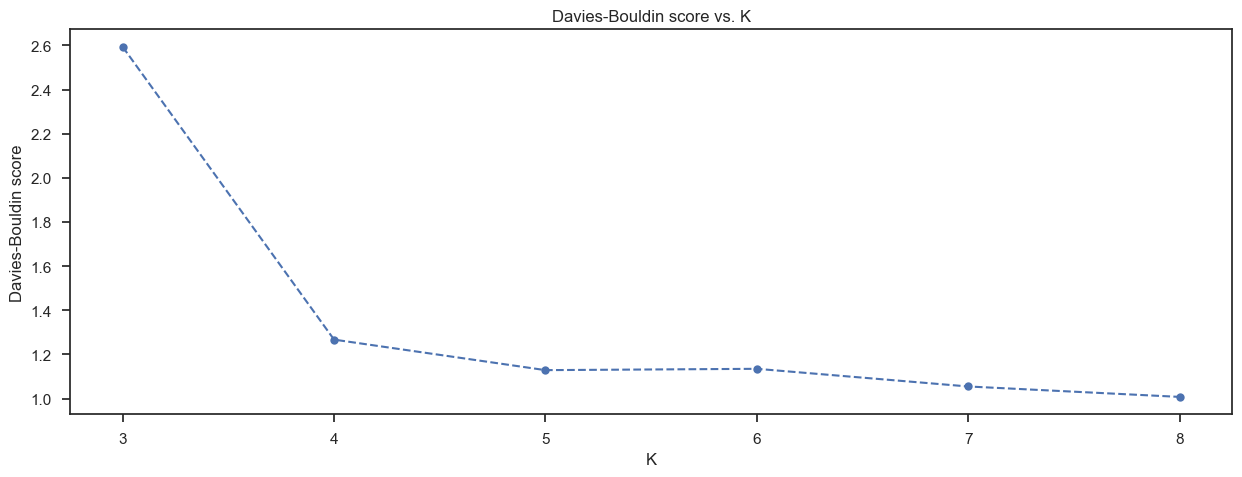

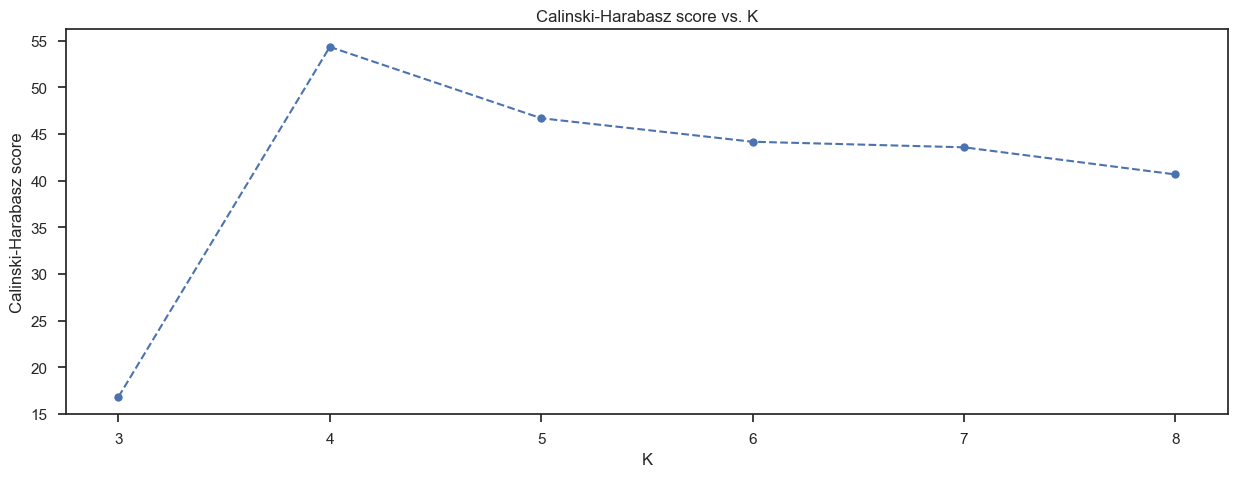

In [21]:
# visualisation des scores des clusters
sns.set_style('ticks')
fonction_clustering.viz_clusters_score(df_cah, 3, 9)

<span style="color:red">**=> Conclusion :**</span>

Meilleurs hyperparamètres :
    
- nombre de clusters : 4   
- méthode : complete
- métrique : manhattan

### Dendrogram visualization

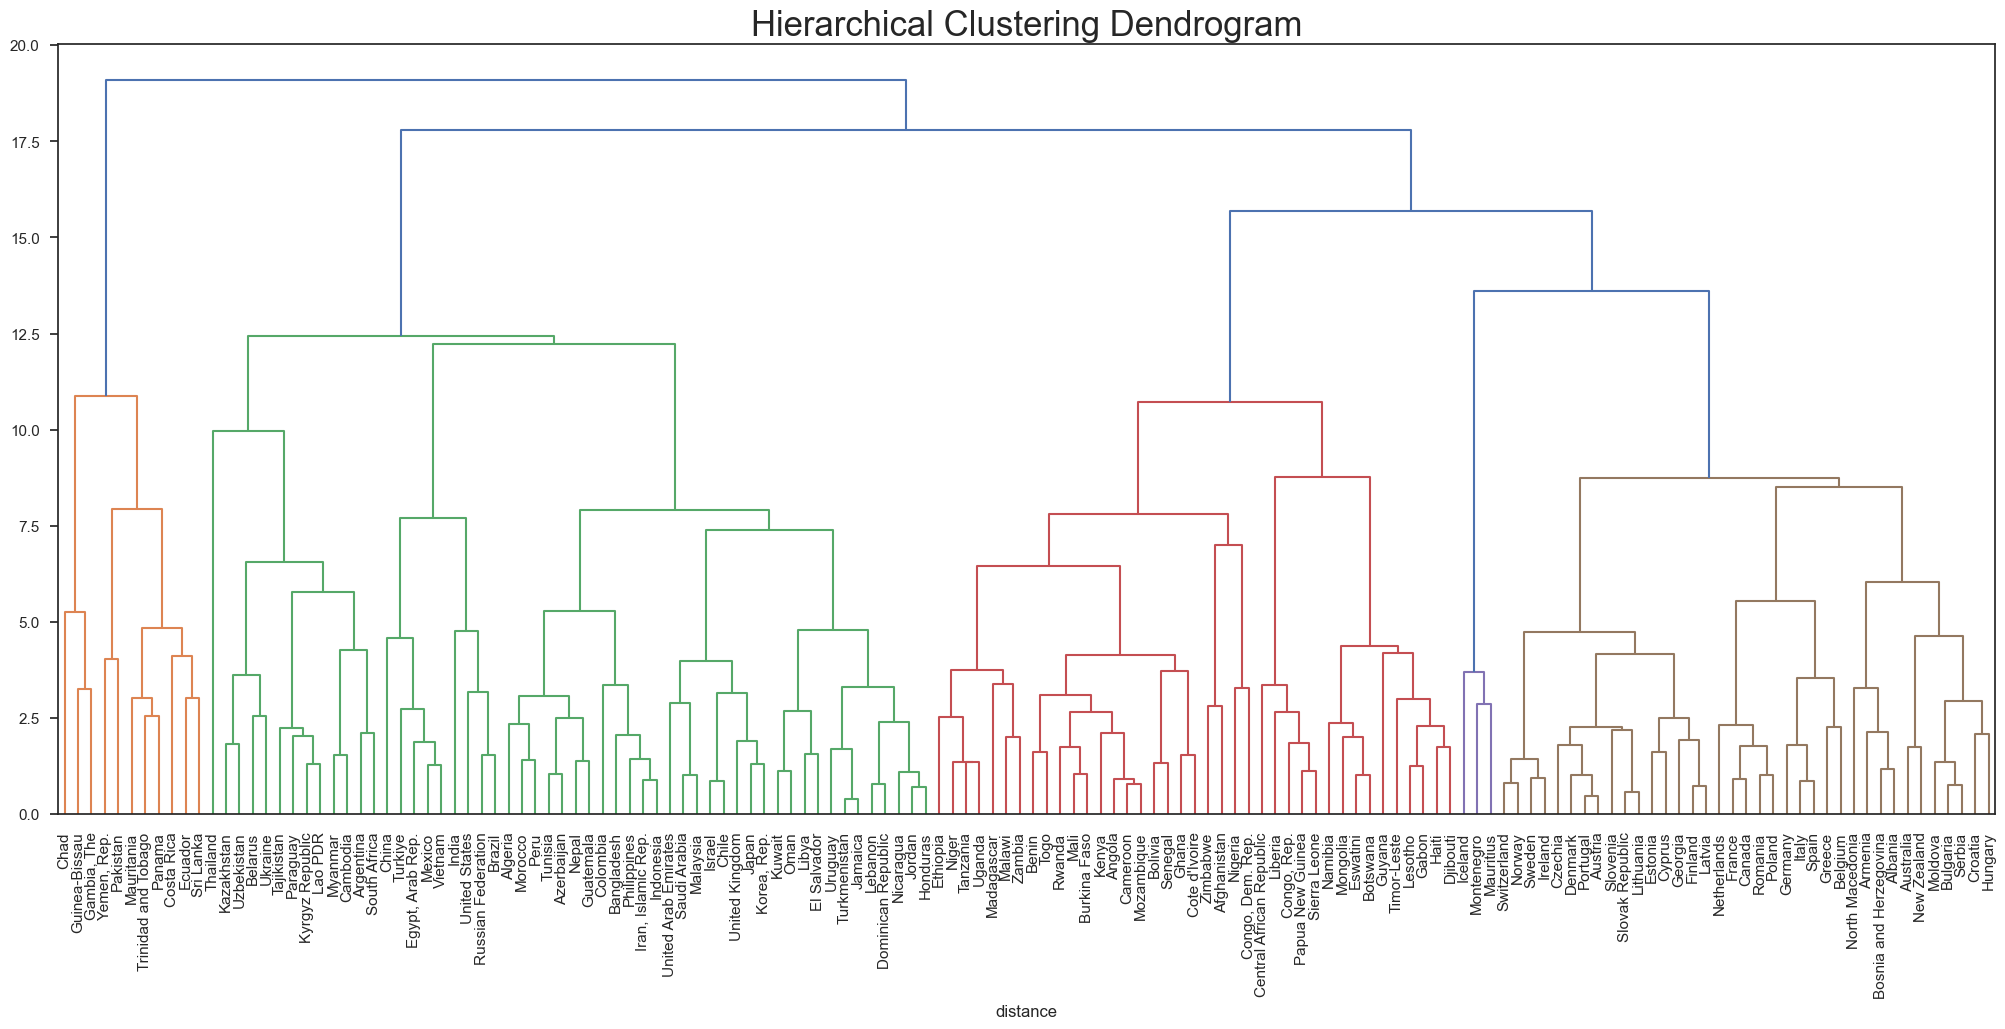

In [22]:
# clustering hiérarchique
Z = linkage(X_projected, 'complete', 'cityblock') # complete method, manhattan metric

# affichage du dendrogramme
sns.set_style('ticks')
plt.figure(figsize=(25,10))
plt.title('Hierarchical Clustering Dendrogram',size=25)
plt.xlabel('distance')
dendrogram(Z,labels = names,leaf_font_size=11, orientation = "top")
plt.savefig('img/saved/HCA.jpeg')
plt.show()

Populating the interactive namespace from numpy and matplotlib


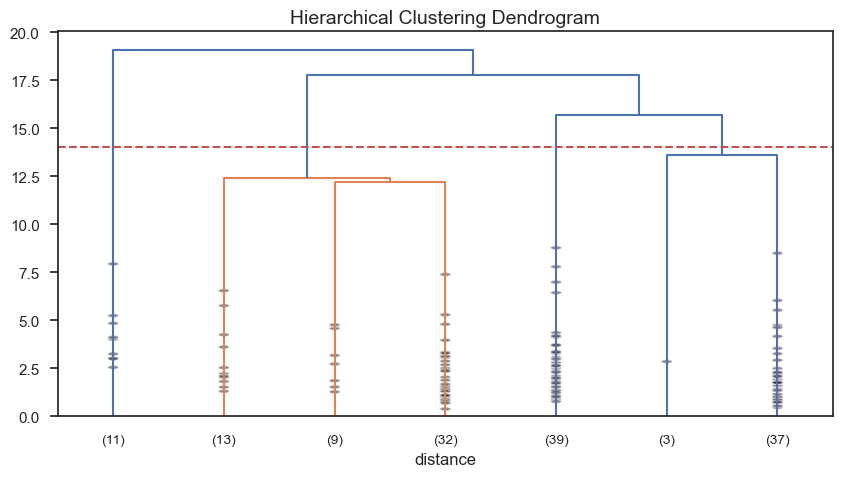

In [23]:
# affichage du dendrogramme simplifié regroupé en 7 branches
%pylab inline
plt.figure(figsize=(10,5))
plt.title('Hierarchical Clustering Dendrogram',size=14)
plt.xlabel('distance')
dendrogram(Z,labels = names, p=7, truncate_mode='lastp', 
           leaf_font_size=10, orientation = "top", 
           show_contracted=True)
plt.axhline(y=14, color='r', linestyle='--')
plt.show()

In [24]:
# on a précédemment détérminé le nombre optimal de clusters = 4 
# donc création de DataFrame à partir du dendrogramme regroupé en 4 branches 
labels = fcluster(Z, 14, criterion='distance')
clusters_cah_pca = pd.DataFrame({'clusters': labels, 'Country': data.index})
clusters_cah_pca.head()   

clusters   Country
0         3    Malawi
1         2   Myanmar
2         3     Kenya
3         3  Zimbabwe
4         3   Nigeria

In [25]:
# comptage d'individus par cluster
clusters_cah_pca["clusters"].value_counts()

2    54
4    40
3    39
1    11
Name: clusters, dtype: int64

In [26]:
# affichage détaillé des individus par cluster 
c1_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 1].drop(columns=('clusters'))
c2_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 2].drop(columns=('clusters'))
c3_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 3].drop(columns=('clusters'))
c4_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 4].drop(columns=('clusters'))

df1_styler = c1_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 1 CAH').set_table_styles(styles)
df2_styler = c2_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 2 CAH').set_table_styles(styles)
df3_styler = c3_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 3 CAH').set_table_styles(styles)
df4_styler = c4_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 4 CAH').set_table_styles(styles)

space = "\xa0" * 10
display_html(df1_styler._repr_html_() + space + df2_styler._repr_html_() + space + df3_styler._repr_html_() \
             + space + df4_styler._repr_html_(), raw=True)

Cluster 1 CAH 
 
 
   
 Country 
 
 
 
 
 5 
 Guinea-Bissau 
 
 
 21 
 Chad 
 
 
 25 
 Ecuador 
 
 
 35 
 Sri Lanka 
 
 
 37 
 Gambia, The 
 
 
 38 
 Yemen, Rep. 
 
 
 50 
 Trinidad and Tobago 
 
 
 57 
 Mauritania 
 
 
 62 
 Panama 
 
 
 68 
 Pakistan 
 
 
 77 
 Costa Rica 
 
 
 
          
 
 Cluster 2 CAH 
 
 
   
 Country 
 
 
 
 
 1 
 Myanmar 
 
 
 6 
 India 
 
 
 7 
 Tajikistan 
 
 
 10 
 Argentina 
 
 
 14 
 Turkmenistan 
 
 
 16 
 Libya 
 
 
 19 
 China 
 
 
 23 
 Tunisia 
 
 
 26 
 Jordan 
 
 
 27 
 Kuwait 
 
 
 29 
 Russian Federation 
 
 
 31 
 Saudi Arabia 
 
 
 32 
 Lebanon 
 
 
 36 
 United Arab Emirates 
 
 
 39 
 Uruguay 
 
 
 43 
 Egypt, Arab Rep. 
 
 
 44 
 Iran, Islamic Rep. 
 
 
 46 
 Cambodia 
 
 
 51 
 Azerbaijan 
 
 
 53 
 Malaysia 
 
 
 54 
 Belarus 
 
 
 55 
 Israel 
 
 
 58 
 Jamaica 
 
 
 59 
 United States 
 
 
 61 
 Dominican Republic 
 
 
 63 
 Algeria 
 
 
 70 
 South Africa 
 
 
 72 
 Mexico 
 
 
 73 
 Japan 
 
 
 81 
 Nicaragua 
 
 
 83 
 Morocco 
 
 
 85 
 Philippines 
 
 
 87 
 United Kingdom 
 
 
 88 
 Nepal 
 
 
 92 
 Oman 
 
 
 93 
 Korea, Rep. 
 
 
 96 
 Indonesia 
 
 
 98 
 Peru 
 
 
 101 
 Paraguay 
 
 
 102 
 Colombia 
 
 
 106 
 Guatemala 
 
 
 112 
 Bangladesh 
 
 
 114 
 Brazil 
 
 
 115 
 El Salvador 
 
 
 117 
 Honduras 
 
 
 120 
 Kazakhstan 
 
 
 127 
 Chile 
 
 
 128 
 Vietnam 
 
 
 133 
 Uzbekistan 
 
 
 134 
 Kyrgyz Republic 
 
 
 139 
 Turkiye 
 
 
 140 
 Thailand 
 
 
 142 
 Ukraine 
 
 
 143 
 Lao PDR 
 
 
 
          
 
 Cluster 3 CAH 
 
 
   
 Country 
 
 
 
 
 0 
 Malawi 
 
 
 2 
 Kenya 
 
 
 3 
 Zimbabwe 
 
 
 4 
 Nigeria 
 
 
 8 
 Bolivia 
 
 
 9 
 Mali 
 
 
 11 
 Papua New Guinea 
 
 
 13 
 Angola 
 
 
 15 
 Madagascar 
 
 
 17 
 Lesotho 
 
 
 18 
 Afghanistan 
 
 
 20 
 Rwanda 
 
 
 22 
 Timor-Leste 
 
 
 24 
 Zambia 
 
 
 28 
 Sierra Leone 
 
 
 40 
 Ghana 
 
 
 41 
 Guyana 
 
 
 42 
 Tanzania 
 
 
 47 
 Central African Republic 
 
 
 49 
 Liberia 
 
 
 56 
 Senegal 
 
 
 69 
 Congo, Rep. 
 
 
 75 
 Gabon 
 
 
 82 
 Benin 
 
 
 86 
 Mongolia 
 
 
 95 
 Cote d'Ivoire 
 
 
 97 
 Congo, Dem. Rep. 
 
 
 99 
 Ethiopia 
 
 
 107 
 Eswatini 
 
 
 111 
 Botswana 
 
 
 116 
 Togo 
 
 
 119 
 Haiti 
 
 
 122 
 Burkina Faso 
 
 
 123 
 Djibouti 
 
 
 129 
 Cameroon 
 
 
 130 
 Mozambique 
 
 
 136 
 Namibia 
 
 
 137 
 Uganda 
 
 
 141 
 Niger 
 
 
 
          
 
 Cluster 4 CAH 
 
 
   
 Country 
 
 
 
 
 12 
 Bulgaria 
 
 
 30 
 North Macedonia 
 
 
 33 
 Bosnia and Herzegovina 
 
 
 34 
 Switzerland 
 
 
 45 
 France 
 
 
 48 
 Montenegro 
 
 
 52 
 Iceland 
 
 
 60 
 Norway 
 
 
 64 
 Portugal 
 
 
 65 
 Australia 
 
 
 66 
 Czechia 
 
 
 67 
 Austria 
 
 
 71 
 Finland 
 
 
 74 
 Estonia 
 
 
 76 
 Slovak Republic 
 
 
 78 
 Mauritius 
 
 
 79 
 Italy 
 
 
 80 
 Greece 
 
 
 84 
 Sweden 
 
 
 89 
 Netherlands 
 
 
 90 
 Belgium 
 
 
 91 
 Latvia 
 
 
 94 
 Croatia 
 
 
 100 
 Georgia 
 
 
 103 
 Romania 
 
 
 104 
 Hungary 
 
 
 105 
 Germany 
 
 
 108 
 Poland 
 
 
 109 
 Ireland 
 
 
 110 
 Spain 
 
 
 113 
 Cyprus 
 
 
 118 
 Canada 
 
 
 121 
 Albania 
 
 
 124 
 Slovenia 
 
 
 125 
 Denmark 
 
 
 126 
 Serbia 
 
 
 131 
 Lithuania 
 
 
 132 
 Moldova 
 
 
 135 
 Armenia 
 
 
 138 
 New Zealand

In [27]:
# jointure => ajout des données ISO au DataFrame pour permettre une visualisation sous format d'une carte mondiale
iso_cah = p9.merge(clusters_cah_pca, how='inner', on='Country')
iso_cah = iso_cah[['iso', 'Country', 'clusters']]
iso_cah.sample()

iso  Country  clusters
94  HRV  Croatia         4

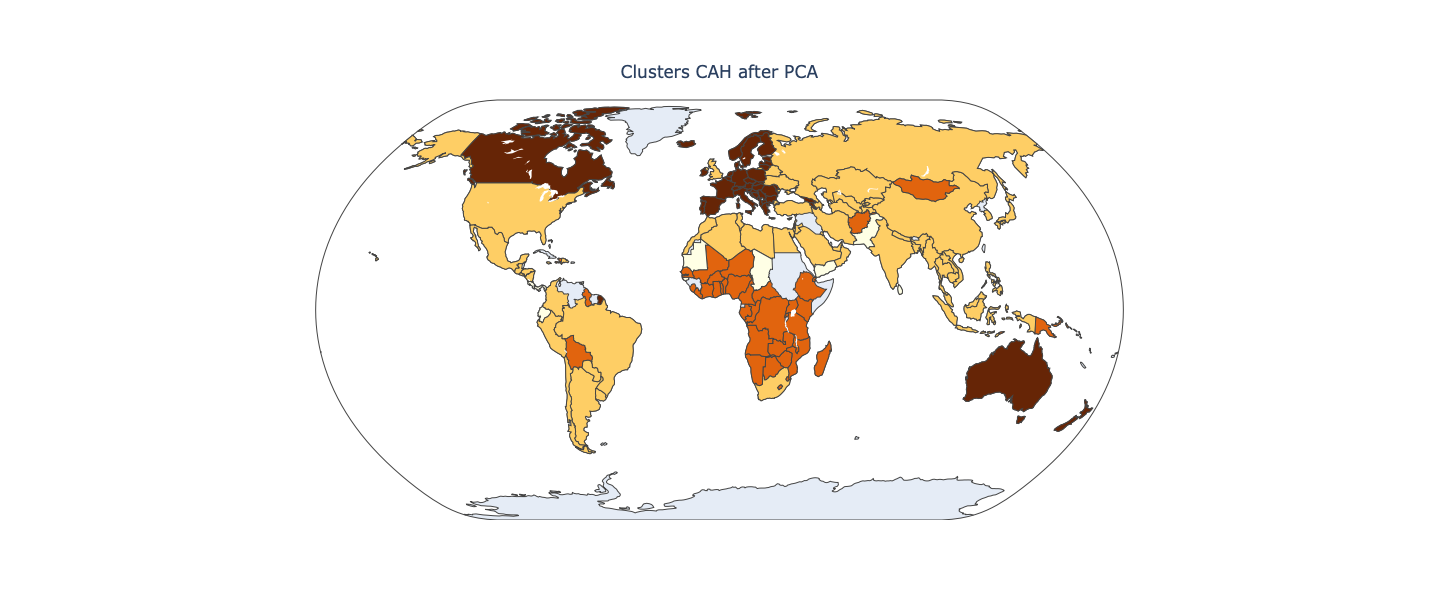

In [28]:
# visualisation carte du monde
fig = px.choropleth(iso_cah, locations="iso", 
              color="clusters", 
              color_continuous_scale=px.colors.sequential.YlOrBr, 
              hover_name="Country", 
              projection="natural earth",
              title="Clusters CAH after PCA" 
              )
fig.update_layout(title_x=0.5, title_y=0.89)
#fig.update_layout(coloraxis_colorbar_title='')
fig.update_coloraxes(showscale=False)
fig.update_layout(width=900, height=600)
fig.add_layout_image(dict(
        xref="paper", yref="paper",
        x=0.65, y=1.15,
        sizex=0.3, sizey=0.3,
        xanchor="right", yanchor="bottom"))

### HCA boxplots

In [29]:
# jointure => ajout des numéros de clusters au DataFrame log d'origine 
p9_cah_pca = p9_log.merge(clusters_cah_pca, on="Country", how="inner")
p9_cah_pca.sample()

Country  Population  Under-nourishment (%)  HDI  Peace_index  \
126  Serbia        6.84                   0.67 0.81         0.45   

     Vegetables disponibility (kg/cap/year)  \
126                                    2.18   

     Enough veg intake (> 91.25 kg/cap/year)  Production  Exportations  \
126                                        1        9.95          9.54   

     Importations  Customs duration (h)  Customs tax (%)  Distance (km)  \
126          8.32                  0.71             0.58           3.16   

     Gdp/cap  Population evolution (4y, %)  Trade balance (exp-imp)  \
126     4.27                         -2.12                     9.51   

     Self-sufficiency (prod-dispo)  Market growth (2y, %)  clusters  
126                           3.06                   1.65         4

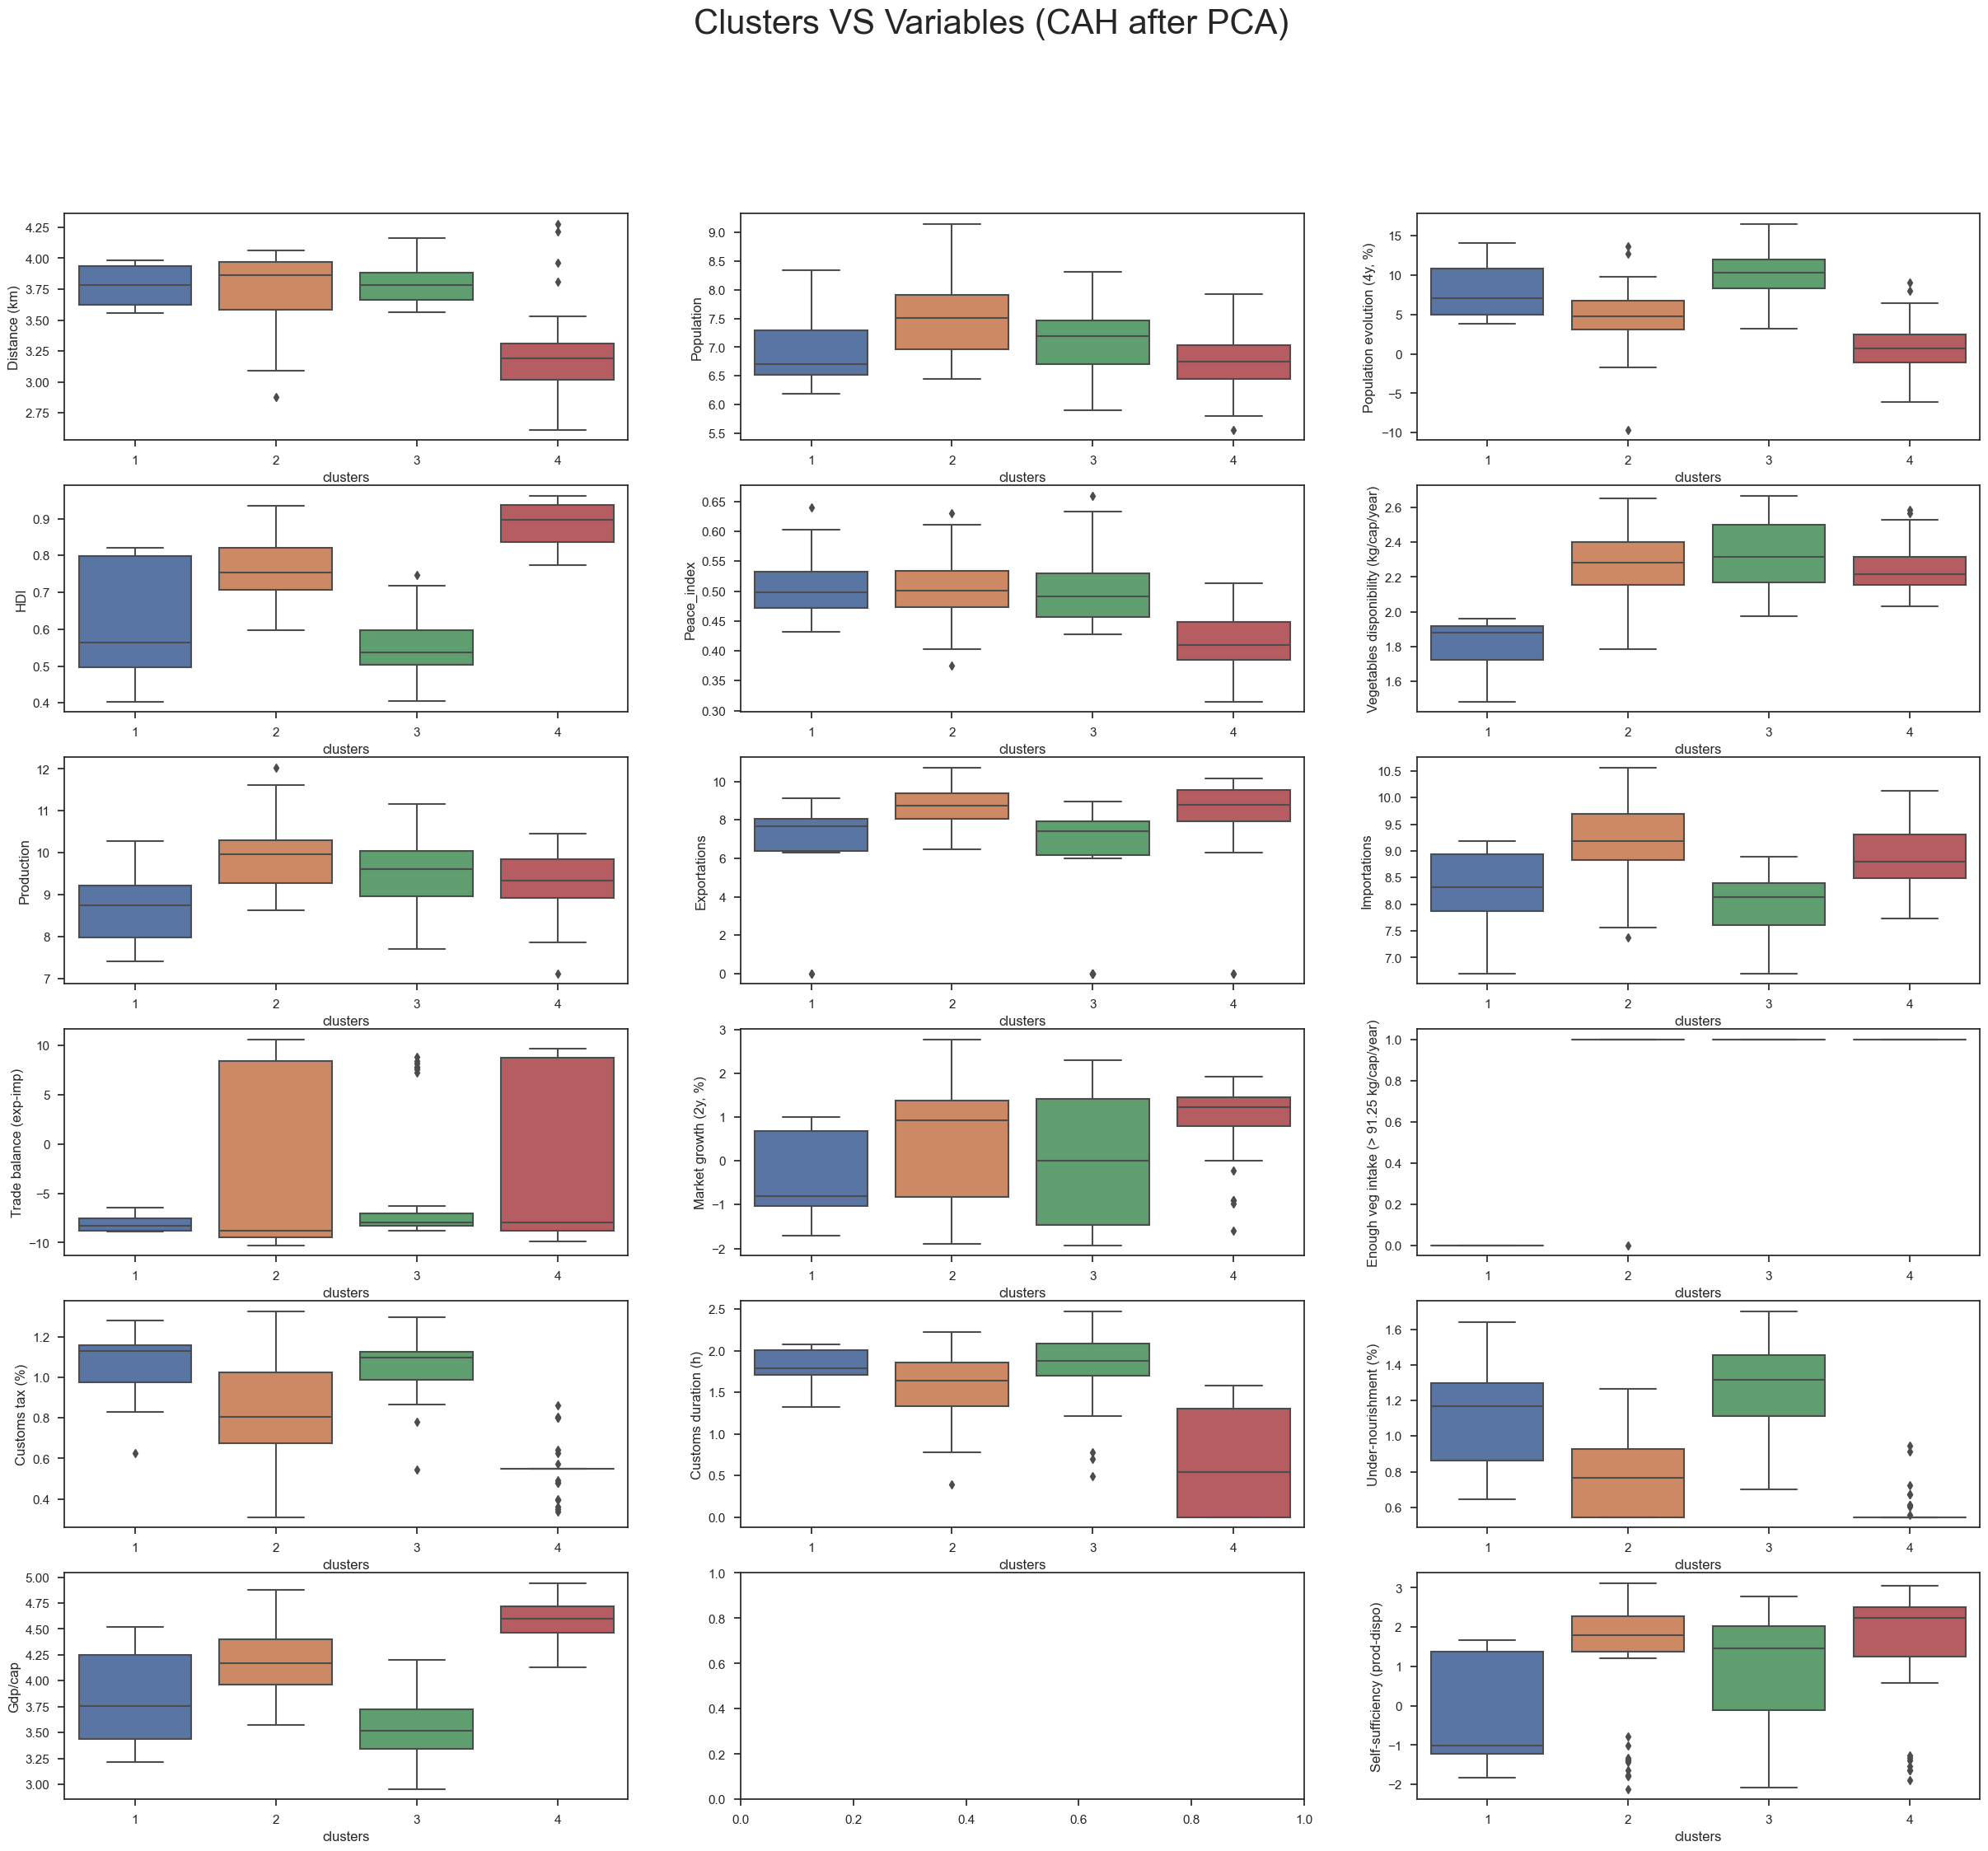

In [30]:
# visualisation boxplots des caractéristiques de chaque cluster 
plt.rcParams['axes.grid'] = False
fig, axes = plt.subplots(6, 3, figsize=(30, 25))

sns.set(font_scale=0.8)
data = p9_cah_pca
x ='clusters'

fig.suptitle('Clusters VS Variables (CAH after PCA)', size=30)
sns.boxplot(ax=axes[0, 0], data=p9_cah_pca, x='clusters', y="Distance (km)")
sns.boxplot(ax=axes[0, 1], data=p9_cah_pca, x='clusters', y="Population")
sns.boxplot(ax=axes[0, 2], data=p9_cah_pca, x='clusters', y='Population evolution (4y, %)')
sns.boxplot(ax=axes[1, 0], data=p9_cah_pca, x='clusters', y='HDI')
sns.boxplot(ax=axes[1, 1], data=p9_cah_pca, x='clusters', y='Peace_index')
sns.boxplot(ax=axes[1, 2], data=p9_cah_pca, x='clusters', y='Vegetables disponibility (kg/cap/year)')
sns.boxplot(ax=axes[2, 0], data=p9_cah_pca, x='clusters', y='Production')
sns.boxplot(ax=axes[2, 1], data=p9_cah_pca, x='clusters', y='Exportations')
sns.boxplot(ax=axes[2, 2], data=p9_cah_pca, x='clusters', y='Importations')
sns.boxplot(ax=axes[3, 0], data=p9_cah_pca, x='clusters', y='Trade balance (exp-imp)')
sns.boxplot(ax=axes[3, 1], data=p9_cah_pca, x='clusters', y='Market growth (2y, %)')
sns.boxplot(ax=axes[3, 2], data=p9_cah_pca, x='clusters', y='Enough veg intake (> 91.25 kg/cap/year)')
sns.boxplot(ax=axes[4, 0], data=p9_cah_pca, x='clusters', y='Customs tax (%)')
sns.boxplot(ax=axes[4, 1], data=p9_cah_pca, x='clusters', y='Customs duration (h)')
sns.boxplot(ax=axes[4, 2], data=p9_cah_pca, x='clusters', y='Under-nourishment (%)')
sns.boxplot(ax=axes[5, 0], data=p9_cah_pca, x='clusters', y='Gdp/cap')
sns.boxplot(ax=axes[5, 2], data=p9_cah_pca, x='clusters', y='Self-sufficiency (prod-dispo)');

**=> Cluster 1 :**
+ IDH moyen à élevé
+ Disponibilité intérieure moyenne à élevée
+ Production élevée
+ Exportation élevée
+ Importation élevée
+ Croissance marché faible à moyen
+ Sous-alim faible à moyen
+ PIB/hab élevé
    
<span style="color:red">**==> Pays développés avec forte disponibilité intérieure, production, exportations et importations élevées, à faible potentiel de croissance du marché**</span>
    
**=> Cluster 2 :**
+ Distance France élevée
+ Faible population
+ IDH moyen
+ Stabilité politique élevée
+ Disponibilité intérieure faible
+ Production faible à moyenne
+ Exportation faible
+ Importation élevée
+ Balance commerciale faible
+ Distance moyenne des pays fournisseurs élevée
+ Croissance marché moyen à élevée
+ Frais de douane faibles
+ Sous-alim moyen
+ PIB/hab moyen

<span style="color:red">**==> Pays moyennement développés, très éloignés de la France et avec faible population (ce qui engendre des frais logistiques supplémentaires) MAIS avec une stabilité politique élevée, une disponibilité intérieure, production et exportations faibles, importations élevées, à moyen potentiel de croissance du marché et avec frais de douane faibles (ce qui peut contrebalancer les frais logistiques supplémentaires), pays ayant l'habitude d'avoir des fournisseurs très éloignés**</span>
        
**=> Cluster 3 :**
+ Distance France élevée
+ Evolution population élevée
+ IDH faible
+ Stabilité politique faible à moyenne
+ Disponibilité intérieure faible à moyenne
+ Production élevée
+ Exportation faible
+ Importation faible à moyen
+ Balance commerciale faible
+ Distance moyenne des pays fournisseurs élevée
+ Croissance marché moyen à élevée
+ Frais de douane élevés
+ Sous-alim élevée
+ PIB/hab faible

<span style="color:red">**==> Pays sous-développés, très éloignés de la France et ayant une forte évolution de la population, avec une stabilité politique plutôt faible, une disponibilité intérieure basse mais production élevée, exportations et importations faibles, il y a un potentiel de croissance du marché mais frais de douane très élevés, pays ayant l'habitude d'avoir des fournisseurs très éloignés**</span>

**=> Cluster 4 :**
+ Distance France élevée
+ Evolution population élevée
+ IDH faible
+ Stabilité politique faible à moyenne
+ Disponibilité intérieure faible à moyenne
+ Production élevée
+ Exportation faible
+ Importation faible à moyen
+ Balance commerciale faible
+ Distance moyenne des pays fournisseurs élevée
+ Croissance marché moyen à élevée
+ Frais de douane élevés
+ Sous-alim élevée
+ PIB/hab faible

<span style="color:red">**==> Pays sous-développés, très éloignés de la France et ayant une forte évolution de la population, avec une stabilité politique plutôt faible, une disponibilité intérieure basse mais production élevée, exportations et importations faibles, il y a un potentiel de croissance du marché mais frais de douane très élevés, pays ayant l'habitude d'avoir des fournisseurs très éloignés**</span>

***D'après les analyses des clusters du CAH, le plus approprié s'avère le Cluster 2***

### Heatmaps

In [31]:
# pour une future visualisation on détermine les labels pour illustrer les clusters sur projection ACP
lab_cah = p9_cah_pca.copy()
lab_cah['Cluster name'] = lab_cah['clusters'].map({1: '2019 Poor and mid-developped countries, lack of vegetables', 
                                                         2: '2019 Biggest productors, exportators and importators, sufficient dispo in vegetables', 
                                                         3: '2019 Poorest under-developped countries, biggest dispo in vegetables', 
                                                         4: '2019 Richest countries, sufficient dispo in vegetables'})

In [32]:
# caractéristiques moyennes par cluster
p9_cah_pca = p9_cah_pca.groupby(by='clusters').mean()
p9_cah_pca

Population  Under-nourishment (%)  HDI  Peace_index  \
clusters                                                        
1               6.95                   1.10 0.63         0.51   
2               7.47                   0.77 0.76         0.50   
3               7.08                   1.27 0.55         0.50   
4               6.81                   0.58 0.88         0.42   

          Vegetables disponibility (kg/cap/year)  \
clusters                                           
1                                           1.81   
2                                           2.28   
3                                           2.32   
4                                           2.24   

          Enough veg intake (> 91.25 kg/cap/year)  Production  Exportations  \
clusters                                                                      
1                                            0.00        8.66          6.23   
2                                            0.98        9.93          8.73   
3                                            1.00        9.45          6.18   
4                                            1.00        9.31          8.27   

          Importations  Customs duration (h)  Customs tax (%)  Distance (km)  \
clusters                                                                       
1                 8.27                  1.79             1.06           3.78   
2                 9.17                  1.56             0.84           3.75   
3                 8.02                  1.83             1.06           3.79   
4                 8.90                  0.65             0.55           3.22   

          Gdp/cap  Population evolution (4y, %)  Trade balance (exp-imp)  \
clusters                                                                   
1            3.85                          8.10                    -8.08   
2            4.18                          4.71                    -3.41   
3            3.54                         10.14                    -5.08   
4            4.56                          0.81                    -2.77   

          Self-sufficiency (prod-dispo)  Market growth (2y, %)  
clusters                                                        
1                                 -0.12                  -0.31  
2                                  1.35                   0.48  
3                                  0.94                   0.06  
4                                  1.55                   0.96

In [33]:
# les données sont centrées et réduites pour mettre à la même échelle les variables au sein des clusters
scaler = preprocessing.StandardScaler()
cah_sc = scaler.fit_transform(p9_cah_pca)
cah_sc = pd.DataFrame(cah_sc, index=p9_cah_pca.index, columns=p9_cah_pca.columns).T
cah_sc

clusters                                    1     2     3     4
Population                              -0.51  1.60  0.00 -1.09
Under-nourishment (%)                    0.64 -0.60  1.25 -1.29
HDI                                     -0.60  0.43 -1.22  1.40
Peace_index                              0.73  0.52  0.48 -1.72
Vegetables disponibility (kg/cap/year)  -1.72  0.56  0.77  0.39
Enough veg intake (> 91.25 kg/cap/year) -1.73  0.55  0.59  0.59
Production                              -1.49  1.31  0.25 -0.06
Exportations                            -0.97  1.19 -1.01  0.79
Importations                            -0.69  1.25 -1.23  0.68
Customs duration (h)                     0.69  0.21  0.79 -1.69
Customs tax (%)                          0.86 -0.18  0.89 -1.56
Distance (km)                            0.61  0.48  0.64 -1.73
Gdp/cap                                 -0.48  0.40 -1.30  1.38
Population evolution (4y, %)             0.61 -0.35  1.19 -1.45
Trade balance (exp-imp)                 -1.58  0.69 -0.12  1.00
Self-sufficiency (prod-dispo)           -1.63  0.65  0.01  0.97
Market growth (2y, %)                   -1.28  0.39 -0.50  1.39

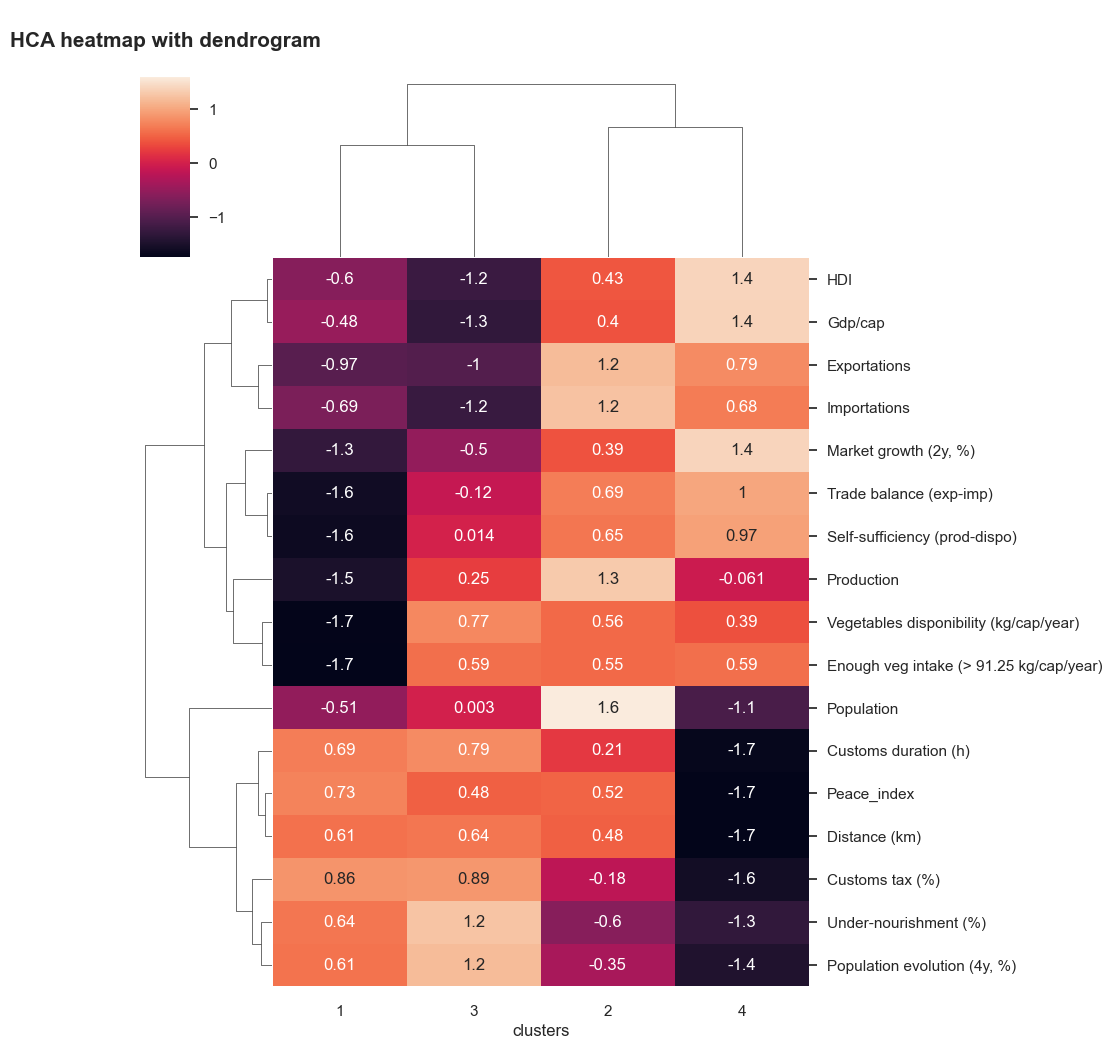

In [34]:
# visualisation heatmap avec dendrogramme
#fig = plt.figure(figsize=(15,12))
sns.set(font_scale=1)
sns.clustermap(cah_sc, annot=True)
plt.title('\nHCA heatmap with dendrogram\n', fontsize=15, fontweight='bold')
plt.savefig('img/saved/HCA_heatmap.jpeg');

### Radar chart

In [35]:
#p9_cah_pca.columns

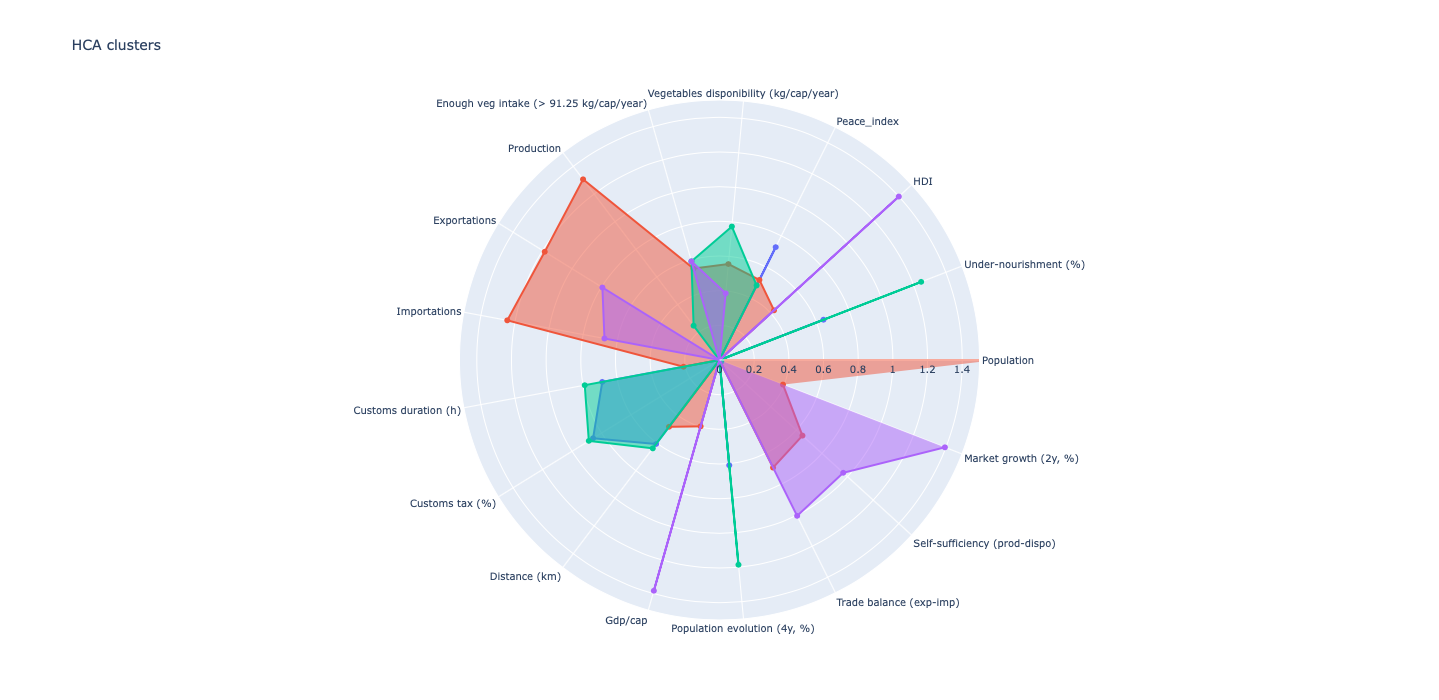

In [36]:
# visualisation radar chart
categories = ['Population', 'Under-nourishment (%)', 'HDI', 'Peace_index',
       'Vegetables disponibility (kg/cap/year)',
       'Enough veg intake (> 91.25 kg/cap/year)', 'Production', 'Exportations',
       'Importations', 'Customs duration (h)', 'Customs tax (%)',
       'Distance (km)', 'Gdp/cap', 'Population evolution (4y, %)',
       'Trade balance (exp-imp)', 'Self-sufficiency (prod-dispo)', 'Market growth (2y, %)']

#fig = plt.figure(figsize=(20,20))
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cah_sc[1],
      theta=categories,
      fill='toself',
      name='C1'
))

fig.add_trace(go.Scatterpolar(
      r=cah_sc[2],
      theta=categories,
      fill='toself',
      name='C2'
))

fig.add_trace(go.Scatterpolar(
      r=cah_sc[3],
      theta=categories,
      fill='toself',
      name='C3'
))

fig.add_trace(go.Scatterpolar(
      r=cah_sc[4],
      theta=categories,
      fill='toself',
      name='C4'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1.5]
    )),
  showlegend=False
)

fig.update_layout(title_text="HCA clusters", font_size=10, width=800, height=700)
fig.show()

### Clusters' projection on PCA F1-F4 components

Populating the interactive namespace from numpy and matplotlib


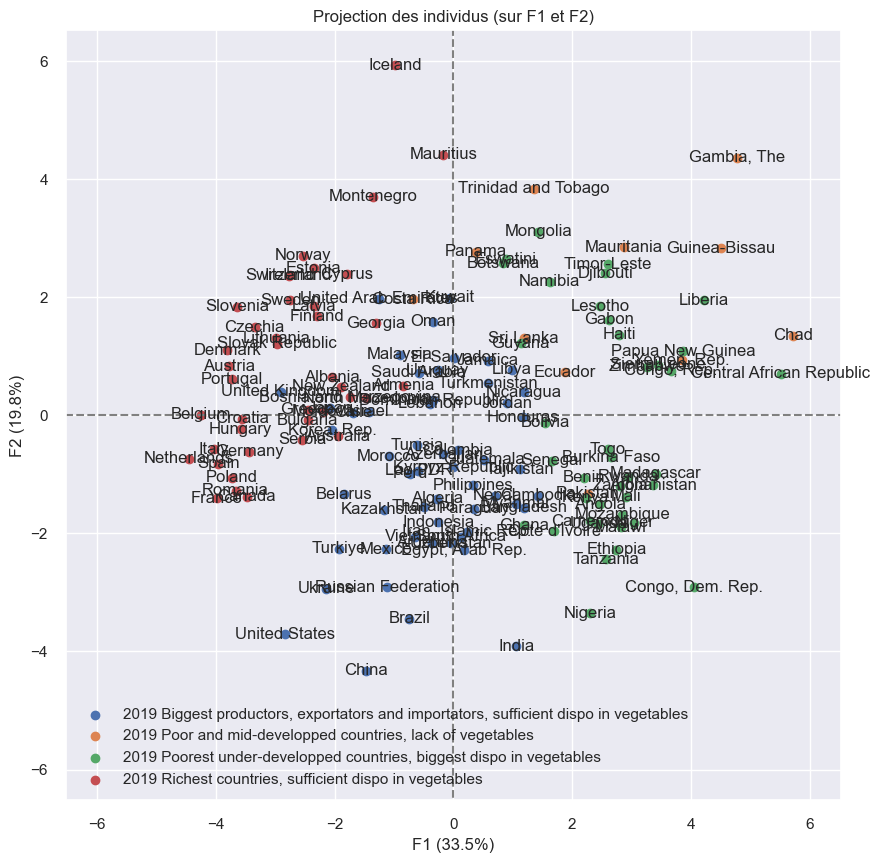

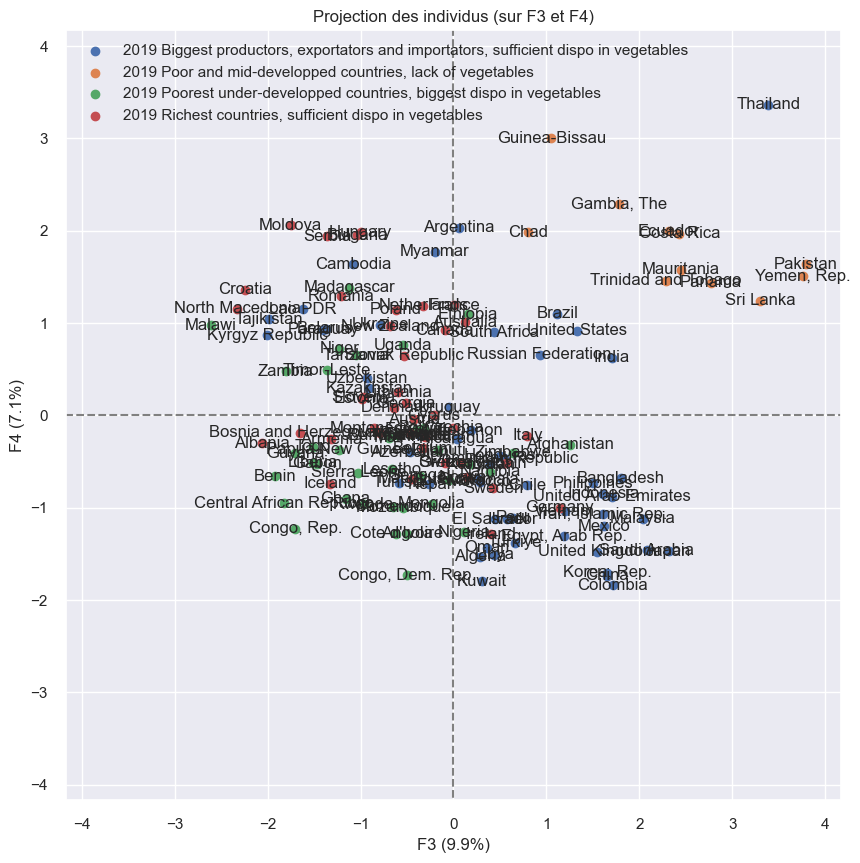

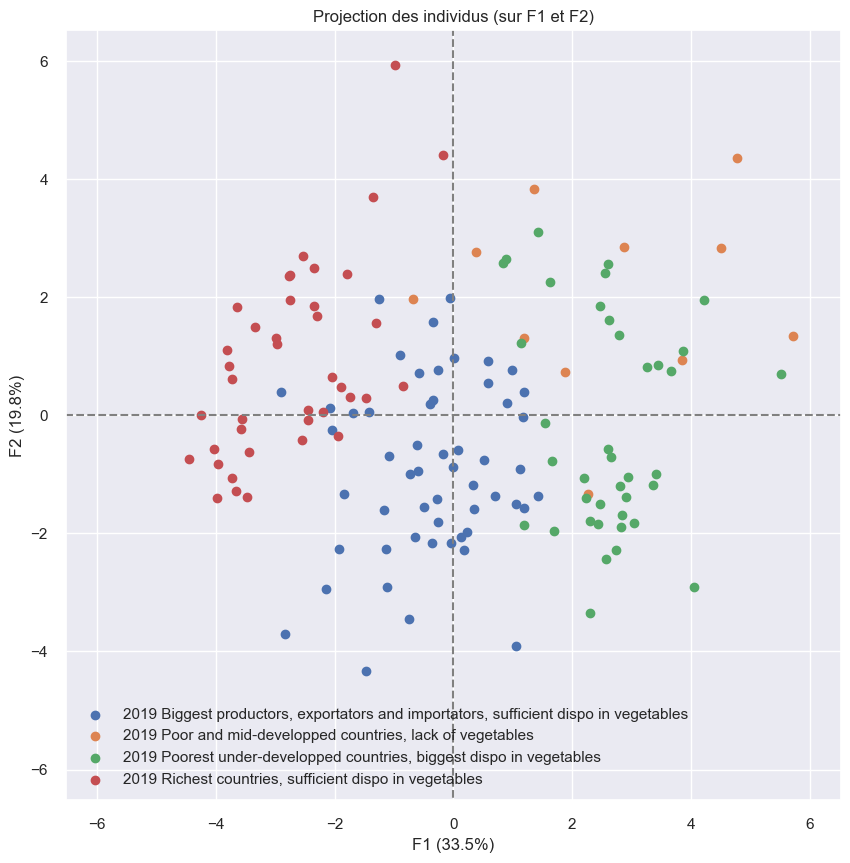

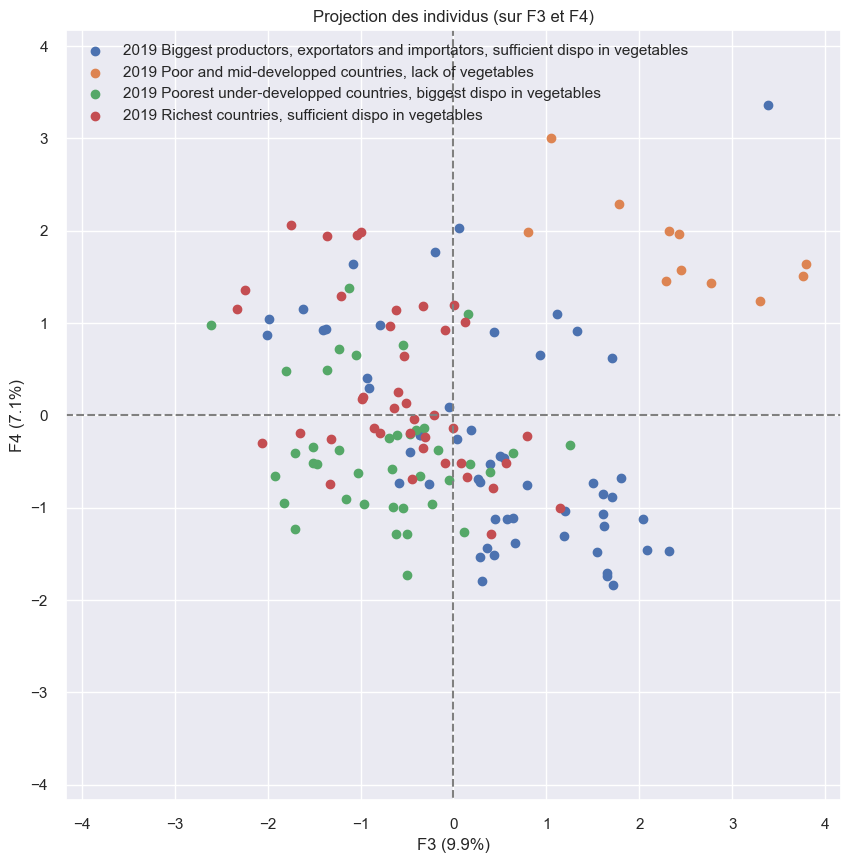

In [37]:
# visualisation projection des individus et clusters
%pylab inline

# projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], 
                         illustrative_var = lab_cah['Cluster name'], 
                         labels = np.array(names))
plt.show()

# projection des individus sans noms des pays
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], 
                         illustrative_var = lab_cah['Cluster name'], 
                         labels = None)
plt.show()

# projection des centroïdes
#df2 = p9_cah_pca.reset_index()
#df2 = df2.drop(columns='clusters')
#X_cah = df2.values
#std_scale_cah = preprocessing.StandardScaler().fit(X_cah)
#X_scaled_cah = std_scale.transform(X_cah)
#X_projected_cah = pca.transform(X_scaled_cah)
#display_factorial_planes(X_projected_cah, n_comp, pca, [(0,1),(2,3)], illustrative_var=['Centroïde 1', 'Centroïde 2', 'Centroïde 3', 'Centroïde 4'])
#plt.show()

## K-means

### Defining the optimal number of clusters

#### Silhouette, Davies-Bouldin, Calinski-Harabasz

In [38]:
# définition de DataFrame vide
df_metrics_kmeans = pd.DataFrame()

In [39]:
# tuning des hyperparamètres n_clusters, linkage, affinity
n_clusters = range(3, 9)
init = ['k-means++', 'random']
random_seed=1
df_metrics_kmeans = \
    fonction_clustering.calcul_metrics_kmeans(X_projected,
                                           df_metrics_kmeans,
                                           'K-Means log PCA', 
                                            random_seed,
                                              n_init = range(1, 4),
                                              init=init, 
                                              n_clusters=n_clusters)
#df_metrics_kmeans.style.hide_index()

In [40]:
# coéfficient de silhouette : le plus proche de 1
df_metrics_kmeans.sort_values(by='silhouette', ascending=False).head(5)

Data type  n_clusters  n_init  type_init  silhouette  \
0   K-Means log PCA           3       1  k-means++        0.30   
3   K-Means log PCA           3       2     random        0.30   
33  K-Means log PCA           8       2     random        0.29   
6   K-Means log PCA           4       1  k-means++        0.29   
10  K-Means log PCA           4       3  k-means++        0.29   

    davies_bouldin  calinski_harabasz  
0             1.19              55.07  
3             1.20              55.05  
33            1.05              52.02  
6             1.15              55.39  
10            1.15              55.39

In [41]:
# indice de Davies-Bouldin : le plus proche de 0
df_metrics_kmeans.sort_values(by='davies_bouldin').head(5)

Data type  n_clusters  n_init  type_init  silhouette  \
33  K-Means log PCA           8       2     random        0.29   
28  K-Means log PCA           7       3  k-means++        0.29   
26  K-Means log PCA           7       2  k-means++        0.29   
24  K-Means log PCA           7       1  k-means++        0.29   
35  K-Means log PCA           8       3     random        0.27   

    davies_bouldin  calinski_harabasz  
33            1.05              52.02  
28            1.09              56.53  
26            1.09              56.53  
24            1.09              56.53  
35            1.09              52.48

In [42]:
# score de Calinski-Harabasz : le plus grand possible
df_metrics_kmeans.sort_values(by='calinski_harabasz', ascending=False).head(5)

Data type  n_clusters  n_init  type_init  silhouette  \
2   K-Means log PCA           3       2  k-means++        0.29   
4   K-Means log PCA           3       3  k-means++        0.29   
9   K-Means log PCA           4       2     random        0.26   
11  K-Means log PCA           4       3     random        0.26   
16  K-Means log PCA           5       3  k-means++        0.27   

    davies_bouldin  calinski_harabasz  
2             1.25              63.92  
4             1.25              63.92  
9             1.26              58.12  
11            1.26              58.12  
16            1.13              57.66

**Conclusion :**
- Silhouette : 3 clusters
- Davies-Bouldin : 8 clusters
- Calinski-Harabasz : 3 clusters

In [43]:
# création de DataFrame pour faciliter la visualisation en utilisant le meilleur score Silhouette
df_kmeans = df_metrics_kmeans[(df_metrics_kmeans['n_init'] == 1) & (df_metrics_kmeans['type_init'] == 'k-means++')]
df_kmeans

Data type  n_clusters  n_init  type_init  silhouette  \
0   K-Means log PCA           3       1  k-means++        0.30   
6   K-Means log PCA           4       1  k-means++        0.29   
12  K-Means log PCA           5       1  k-means++        0.29   
18  K-Means log PCA           6       1  k-means++        0.26   
24  K-Means log PCA           7       1  k-means++        0.29   
30  K-Means log PCA           8       1  k-means++        0.27   

    davies_bouldin  calinski_harabasz  
0             1.19              55.07  
6             1.15              55.39  
12            1.18              57.59  
18            1.12              56.06  
24            1.09              56.53  
30            1.11              52.90

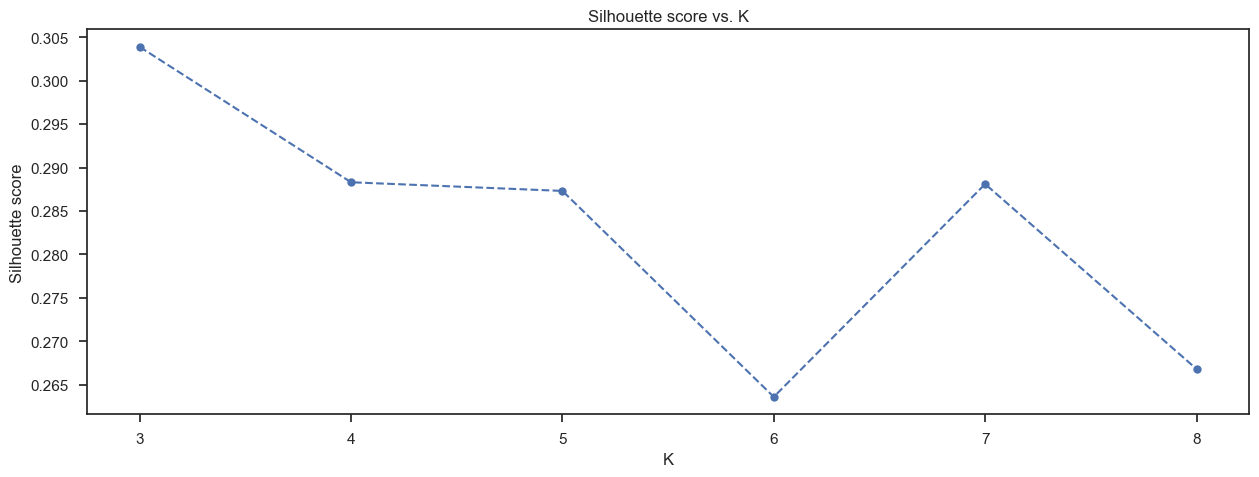

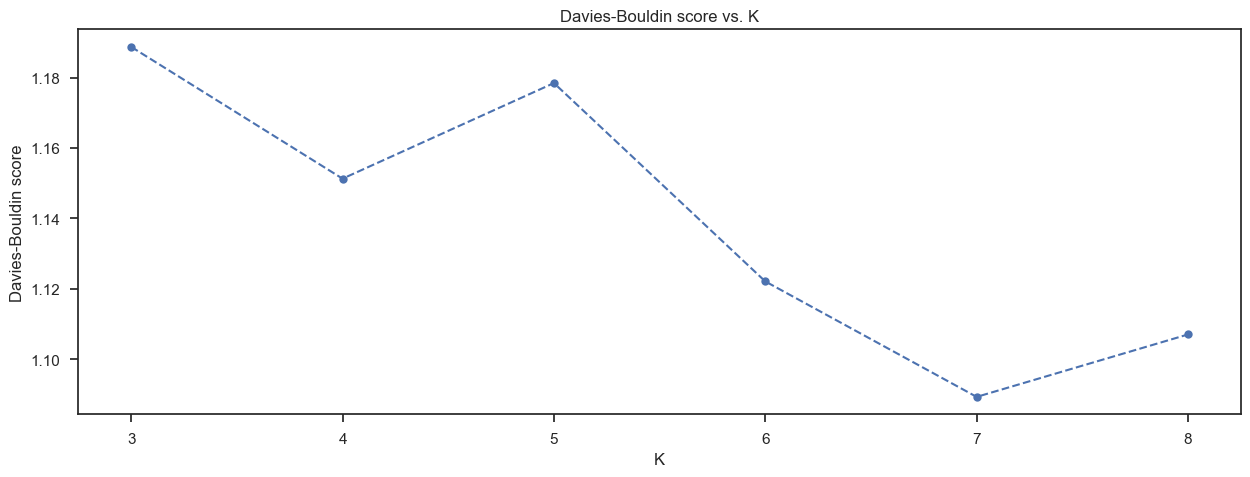

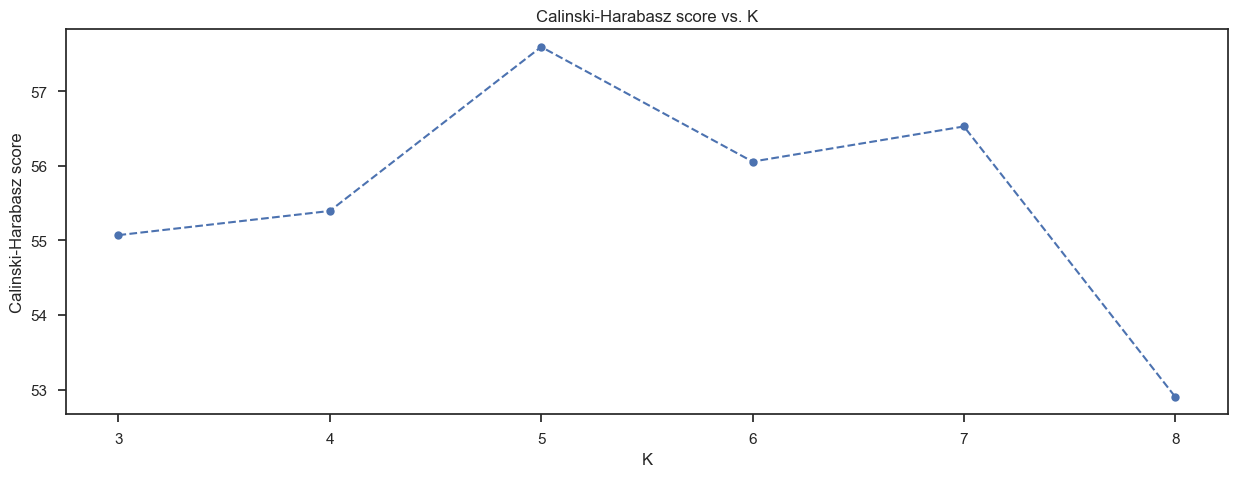

In [44]:
# visualisation des scores des clusters
sns.set_style('ticks')
fonction_clustering.viz_clusters_score(df_kmeans, 3, 9)

<span style="color:red">**=> Conclusion :**</span>

Meilleurs hyperparamètres :
    
- nombre de clusters : 3
- type init : k-means++

#### Elbow method

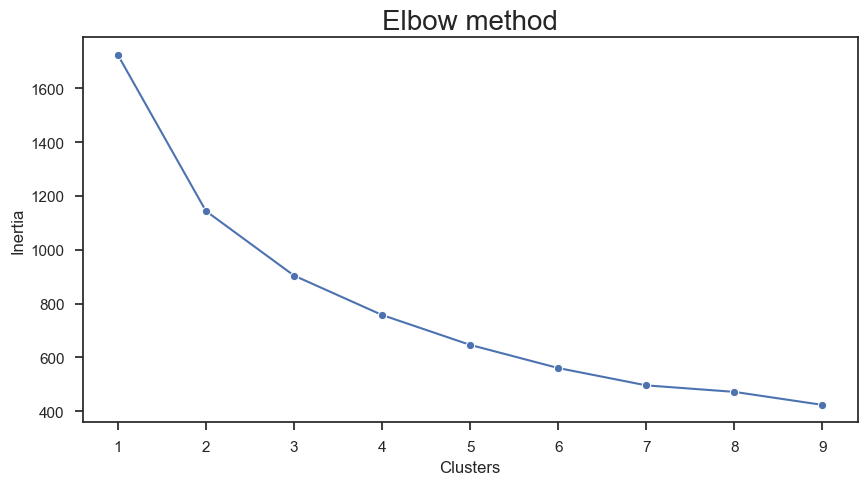

In [45]:
# visualisation méthode du coude
clusters = []

for i in range(1, 10):
    km = KMeans(n_clusters=i).fit(X_projected)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=list(range(1, 10)), y=clusters, ax=ax,marker="o")

ax.set_title('Elbow method',size=20)
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')
plt.show()

In [46]:
# fonction basée sur la méthode du coude calculant le nombre optimal de clusters
kl = KneeLocator (range(1, 10), clusters, curve="convex", direction="decreasing")
print('The optimal number of clusters :', kl.elbow)

The optimal number of clusters : 3


#### Silhouette visualization

For n_clusters = 2 The average silhouette_score is : 0.29513019977270766
For n_clusters = 3 The average silhouette_score is : 0.28655664153883964
For n_clusters = 4 The average silhouette_score is : 0.27142188827585273


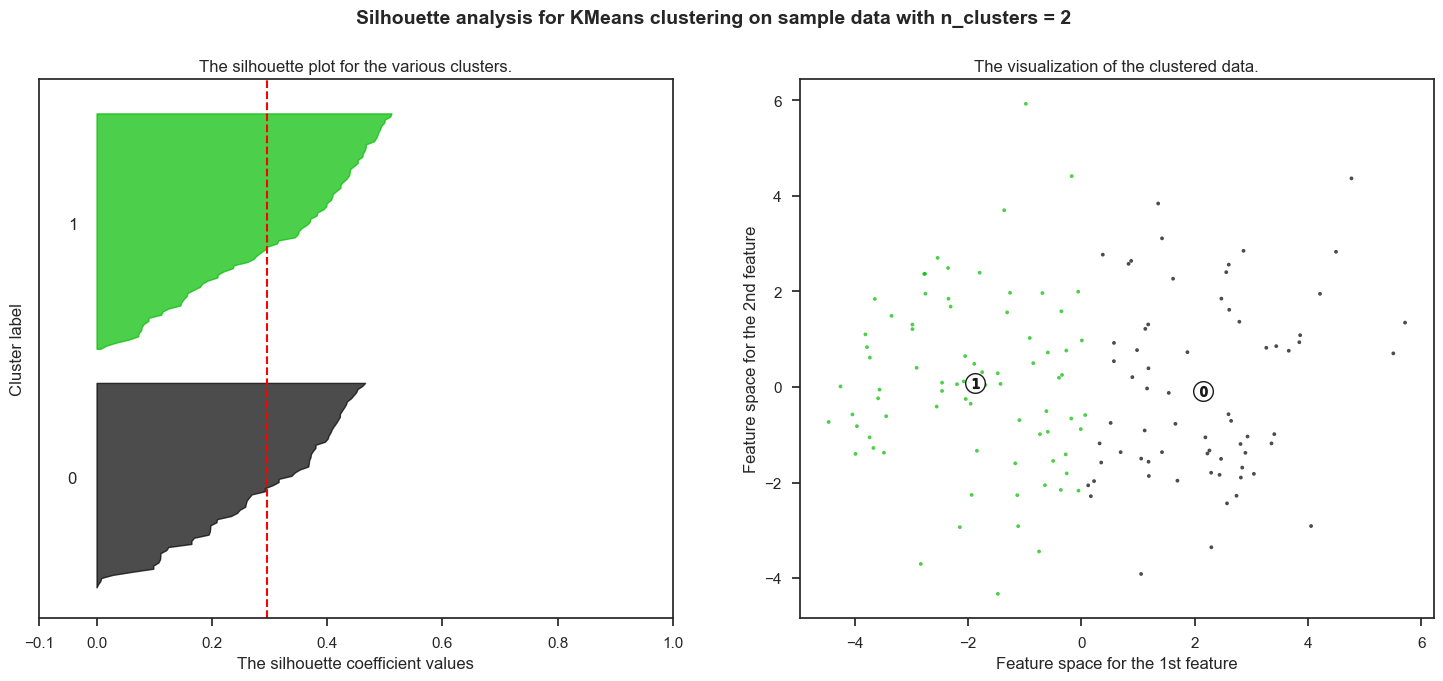

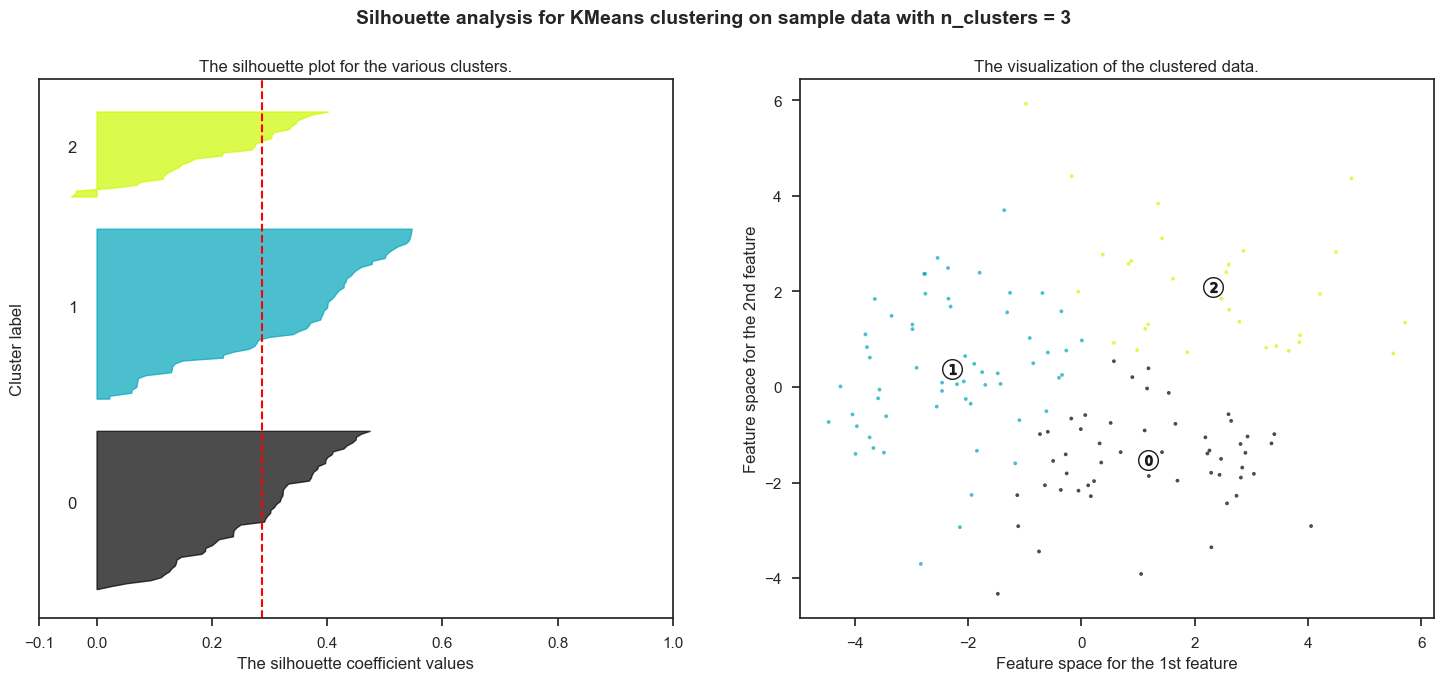

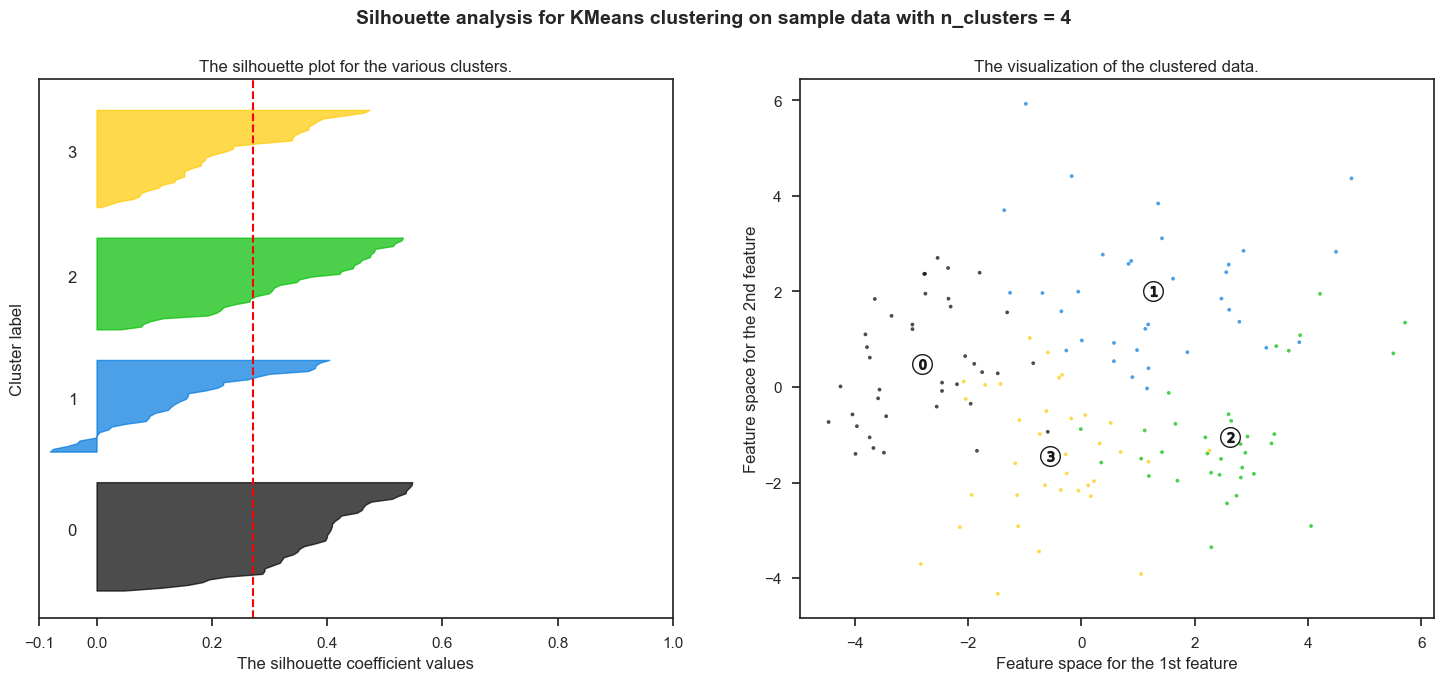

In [47]:
# visualisation des silhouettes
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_projected)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_projected, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_projected, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_projected[:, 0], X_projected[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.savefig('img/saved/silhouette_km.jpeg')
plt.show()

<span style="color:red">**=> Le score maximum de Silhouette indique le nombre de clusters optimum**</span>

<span style="color:red">**=> Dans le cas présent nous choisirons donc 3, nombre optimum de clusters qui est également confirmé par la méthode du coude**</span>

#### Gap statistic

In [48]:
# ne fonctionne pas avec CAH
def KMeans_clustering_func(X, k):
    # include any clustering Algorithm that can return cluster centers
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    # return the location of each cluster center and the labels for each point
    return m.cluster_centers_, m.predict(X)

# create a wrapper around OptimalK to extract cluster centers and cluster labels
optimalK = OptimalK(clusterer=KMeans_clustering_func)

# run optimal K on the input data (subset_scaled_interim) and number of clusters
n_clusters = optimalK(X_projected, cluster_array=np.arange(1, 10))
#print('Optimal clusters: ', n_clusters)

# gap Statistics data frame
optimalK.gap_df[['n_clusters', 'gap_value']]

n_clusters  gap_value
0        1.00       0.65
1        2.00       0.68
2        3.00       0.67
3        4.00       0.61
4        5.00       0.64
5        6.00       0.67
6        7.00       0.70
7        8.00       0.73
8        9.00       0.74

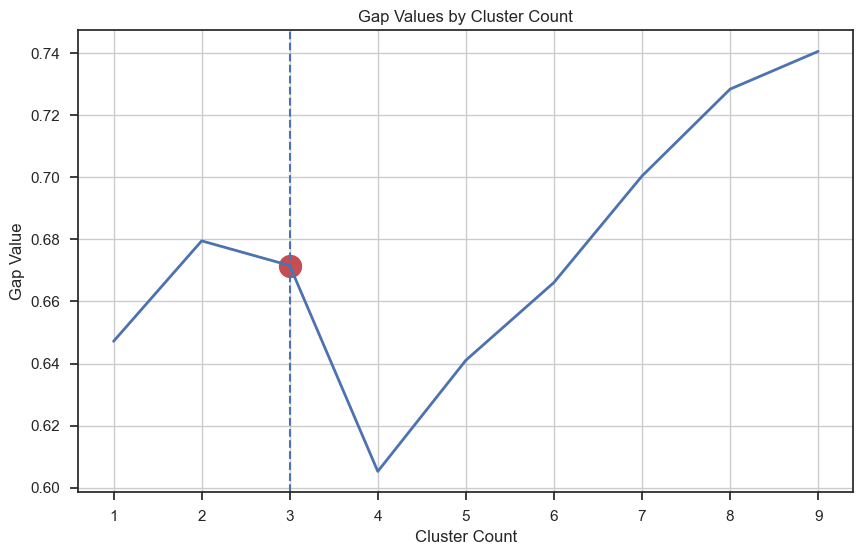

In [49]:
# visualisation des valeurs de gap
plt.figure(figsize=(10,6))
n_clusters=3
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=2)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.axvline(3, linestyle="--")
plt.savefig('img/saved/gap_stat.jpeg')
plt.show()

*=> Confirme le nombre de clusters optimal = 3*

### Centroids visualization

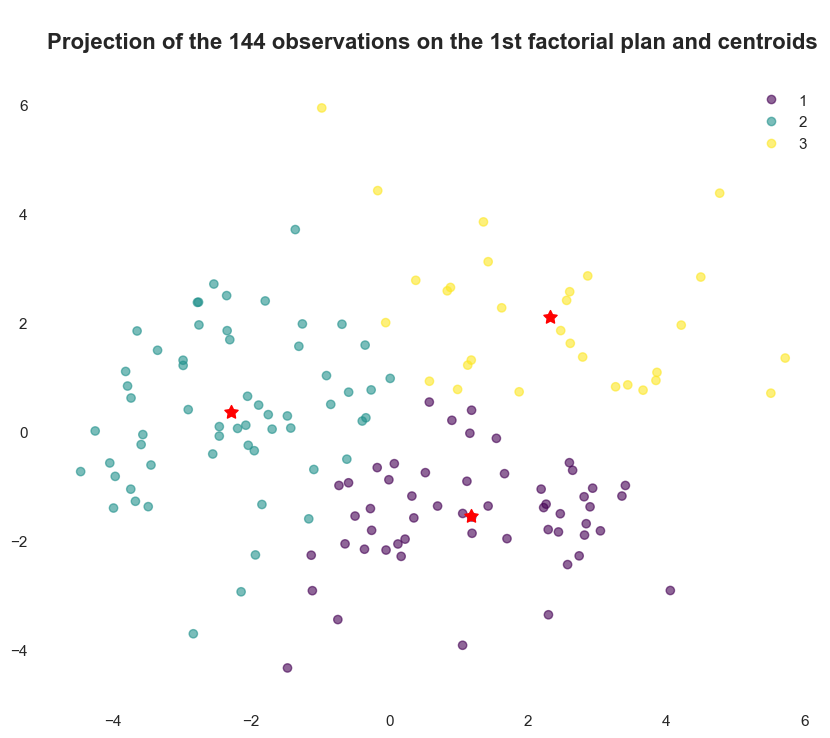

In [50]:
# visualisation des centroïdes
sns.set(font_scale=1)
# nombre de clusters souhaités
n_clust = 3

# import de l'échantillon
data = p9_log

# préparation des données pour le clustering
X = data.values
X_scaled = preprocessing.StandardScaler().fit_transform(X)

pca = decomposition.PCA(n_components=4).fit(X_scaled)
X_projected = pca.transform(X_scaled)

# clustering par K-means
km_acp = KMeans(n_clusters=n_clust,random_state=3)
km_acp.fit(X_projected)

# récupération des clusters attribués à chaque individu
clusters = km_acp.labels_

# affichage du clustering par projection des individus sur le premier plan factoriel
fig=plt.figure(figsize=(10,8))
ax = plt.axes()
ax.set_facecolor("white")
scatter=plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters, cmap = 'viridis', alpha=0.6)
classes=["1","2","3","4"]
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
#for i,(x,y) in enumerate(X_projected[:,[0,1]]):
                    #plt.text(x, y, df.index[i], fontsize='13')(si on voulait afficher les noms des individus)

plt.title(f"\nProjection of the {X_projected.shape[0]} observations on the 1st factorial plan and centroids\n", size=16, fontweight='bold')

# on définit les cluster centers: centroids
centroids=np.array(km_acp.cluster_centers_)
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# on fait un scatter plot des centroids_x et centroids_y
plt.scatter(centroids_x, centroids_y, marker=(5, 1), s=100, c="red", alpha=1)

plt.savefig('img/saved/km_projection.jpeg')
plt.show()

In [51]:
# comptage d'individus par cluster
liste_pays_km_acp = pd.DataFrame({"Country":p9_log.index,"Clusters":clusters+1})
liste_pays_km_acp["Clusters"].value_counts()

2    59
1    55
3    30
Name: Clusters, dtype: int64

In [52]:
# affichage détaillé des individus par cluster 
c1_km_acp = liste_pays_km_acp[liste_pays_km_acp["Clusters"] == 1].drop(columns=('Clusters'))
c2_km_acp = liste_pays_km_acp[liste_pays_km_acp["Clusters"] == 2].drop(columns=('Clusters'))
c3_km_acp = liste_pays_km_acp[liste_pays_km_acp["Clusters"] == 3].drop(columns=('Clusters'))

df1_styler = c1_km_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 1 K-means').set_table_styles(styles)
df2_styler = c2_km_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 2 K-Means').set_table_styles(styles)
df3_styler = c3_km_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 3 K-Means').set_table_styles(styles)

space = "\xa0" * 10
display_html(df1_styler._repr_html_() + space + df2_styler._repr_html_() + space + df3_styler._repr_html_(), raw=True)

Cluster 1 K-means 
 
 
   
 Country 
 
 
 
 
 0 
 Malawi 
 
 
 1 
 Myanmar 
 
 
 2 
 Kenya 
 
 
 4 
 Nigeria 
 
 
 6 
 India 
 
 
 7 
 Tajikistan 
 
 
 8 
 Bolivia 
 
 
 9 
 Mali 
 
 
 10 
 Argentina 
 
 
 13 
 Angola 
 
 
 14 
 Turkmenistan 
 
 
 15 
 Madagascar 
 
 
 18 
 Afghanistan 
 
 
 19 
 China 
 
 
 20 
 Rwanda 
 
 
 24 
 Zambia 
 
 
 26 
 Jordan 
 
 
 29 
 Russian Federation 
 
 
 40 
 Ghana 
 
 
 42 
 Tanzania 
 
 
 43 
 Egypt, Arab Rep. 
 
 
 44 
 Iran, Islamic Rep. 
 
 
 46 
 Cambodia 
 
 
 51 
 Azerbaijan 
 
 
 56 
 Senegal 
 
 
 63 
 Algeria 
 
 
 68 
 Pakistan 
 
 
 70 
 South Africa 
 
 
 72 
 Mexico 
 
 
 81 
 Nicaragua 
 
 
 82 
 Benin 
 
 
 85 
 Philippines 
 
 
 88 
 Nepal 
 
 
 95 
 Cote d'Ivoire 
 
 
 96 
 Indonesia 
 
 
 97 
 Congo, Dem. Rep. 
 
 
 98 
 Peru 
 
 
 99 
 Ethiopia 
 
 
 101 
 Paraguay 
 
 
 102 
 Colombia 
 
 
 106 
 Guatemala 
 
 
 112 
 Bangladesh 
 
 
 114 
 Brazil 
 
 
 116 
 Togo 
 
 
 117 
 Honduras 
 
 
 122 
 Burkina Faso 
 
 
 128 
 Vietnam 
 
 
 129 
 Cameroon 
 
 
 130 
 Mozambique 
 
 
 133 
 Uzbekistan 
 
 
 134 
 Kyrgyz Republic 
 
 
 137 
 Uganda 
 
 
 140 
 Thailand 
 
 
 141 
 Niger 
 
 
 143 
 Lao PDR 
 
 
 
          
 
 Cluster 2 K-Means 
 
 
   
 Country 
 
 
 
 
 12 
 Bulgaria 
 
 
 23 
 Tunisia 
 
 
 30 
 North Macedonia 
 
 
 31 
 Saudi Arabia 
 
 
 32 
 Lebanon 
 
 
 33 
 Bosnia and Herzegovina 
 
 
 34 
 Switzerland 
 
 
 36 
 United Arab Emirates 
 
 
 39 
 Uruguay 
 
 
 45 
 France 
 
 
 48 
 Montenegro 
 
 
 53 
 Malaysia 
 
 
 54 
 Belarus 
 
 
 55 
 Israel 
 
 
 59 
 United States 
 
 
 60 
 Norway 
 
 
 61 
 Dominican Republic 
 
 
 64 
 Portugal 
 
 
 65 
 Australia 
 
 
 66 
 Czechia 
 
 
 67 
 Austria 
 
 
 71 
 Finland 
 
 
 73 
 Japan 
 
 
 74 
 Estonia 
 
 
 76 
 Slovak Republic 
 
 
 77 
 Costa Rica 
 
 
 79 
 Italy 
 
 
 80 
 Greece 
 
 
 83 
 Morocco 
 
 
 84 
 Sweden 
 
 
 87 
 United Kingdom 
 
 
 89 
 Netherlands 
 
 
 90 
 Belgium 
 
 
 91 
 Latvia 
 
 
 92 
 Oman 
 
 
 93 
 Korea, Rep. 
 
 
 94 
 Croatia 
 
 
 100 
 Georgia 
 
 
 103 
 Romania 
 
 
 104 
 Hungary 
 
 
 105 
 Germany 
 
 
 108 
 Poland 
 
 
 109 
 Ireland 
 
 
 110 
 Spain 
 
 
 113 
 Cyprus 
 
 
 115 
 El Salvador 
 
 
 118 
 Canada 
 
 
 120 
 Kazakhstan 
 
 
 121 
 Albania 
 
 
 124 
 Slovenia 
 
 
 125 
 Denmark 
 
 
 126 
 Serbia 
 
 
 127 
 Chile 
 
 
 131 
 Lithuania 
 
 
 132 
 Moldova 
 
 
 135 
 Armenia 
 
 
 138 
 New Zealand 
 
 
 139 
 Turkiye 
 
 
 142 
 Ukraine 
 
 
 
          
 
 Cluster 3 K-Means 
 
 
   
 Country 
 
 
 
 
 3 
 Zimbabwe 
 
 
 5 
 Guinea-Bissau 
 
 
 11 
 Papua New Guinea 
 
 
 16 
 Libya 
 
 
 17 
 Lesotho 
 
 
 21 
 Chad 
 
 
 22 
 Timor-Leste 
 
 
 25 
 Ecuador 
 
 
 27 
 Kuwait 
 
 
 28 
 Sierra Leone 
 
 
 35 
 Sri Lanka 
 
 
 37 
 Gambia, The 
 
 
 38 
 Yemen, Rep. 
 
 
 41 
 Guyana 
 
 
 47 
 Central African Republic 
 
 
 49 
 Liberia 
 
 
 50 
 Trinidad and Tobago 
 
 
 52 
 Iceland 
 
 
 57 
 Mauritania 
 
 
 58 
 Jamaica 
 
 
 62 
 Panama 
 
 
 69 
 Congo, Rep. 
 
 
 75 
 Gabon 
 
 
 78 
 Mauritius 
 
 
 86 
 Mongolia 
 
 
 107 
 Eswatini 
 
 
 111 
 Botswana 
 
 
 119 
 Haiti 
 
 
 123 
 Djibouti 
 
 
 136 
 Namibia

In [53]:
# jointure => ajout des données ISO au DataFrame pour permettre une visualisation sous format d'une carte mondiale
iso_cah = p9.merge(liste_pays_km_acp, how='inner', on='Country')
iso_cah = iso_cah[['iso', 'Country', 'Clusters']]
iso_cah.sample()

iso    Country  Clusters
35  LKA  Sri Lanka         3

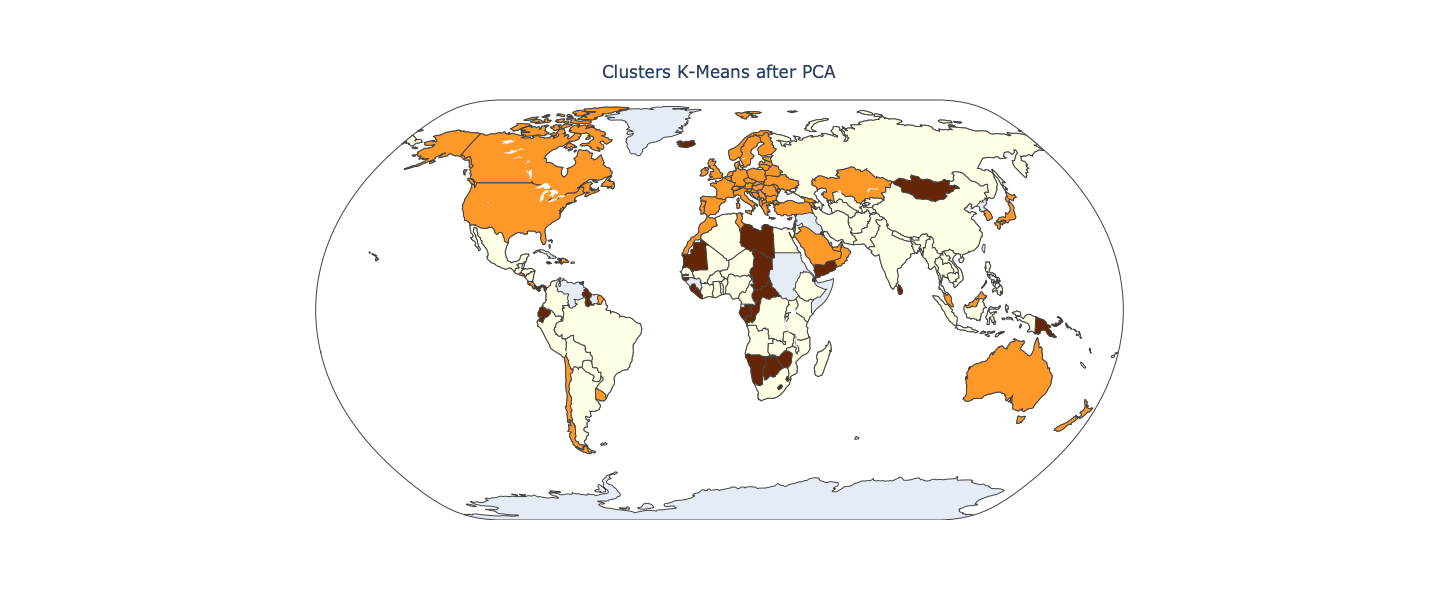

In [54]:
# visualisation carte du monde
fig = px.choropleth(iso_cah, locations="iso", 
              color="Clusters", 
              color_continuous_scale=px.colors.sequential.YlOrBr, 
              hover_name="Country", 
              projection="natural earth",
              title="Clusters K-Means after PCA" 
              )
fig.update_layout(title_x=0.5, title_y=0.89)
#fig.update_layout(coloraxis_colorbar_title='')
fig.update_coloraxes(showscale=False)
fig.update_layout(width=900, height=600)
fig.add_layout_image(dict(
        xref="paper", yref="paper",
        x=0.65, y=1.15,
        sizex=0.3, sizey=0.3,
        xanchor="right", yanchor="bottom"))

### K-Means boxplots

In [55]:
# jointure => ajout des numéros de clusters au DataFrame log d'origine 
p9_km_acp = p9_log.merge(liste_pays_km_acp, on="Country", how='inner')
p9_km_acp.columns

Index(['Country', 'Population', 'Under-nourishment (%)', 'HDI', 'Peace_index',
       'Vegetables disponibility (kg/cap/year)',
       'Enough veg intake (> 91.25 kg/cap/year)', 'Production', 'Exportations',
       'Importations', 'Customs duration (h)', 'Customs tax (%)',
       'Distance (km)', 'Gdp/cap', 'Population evolution (4y, %)',
       'Trade balance (exp-imp)', 'Self-sufficiency (prod-dispo)',
       'Market growth (2y, %)', 'Clusters'],
      dtype='object')

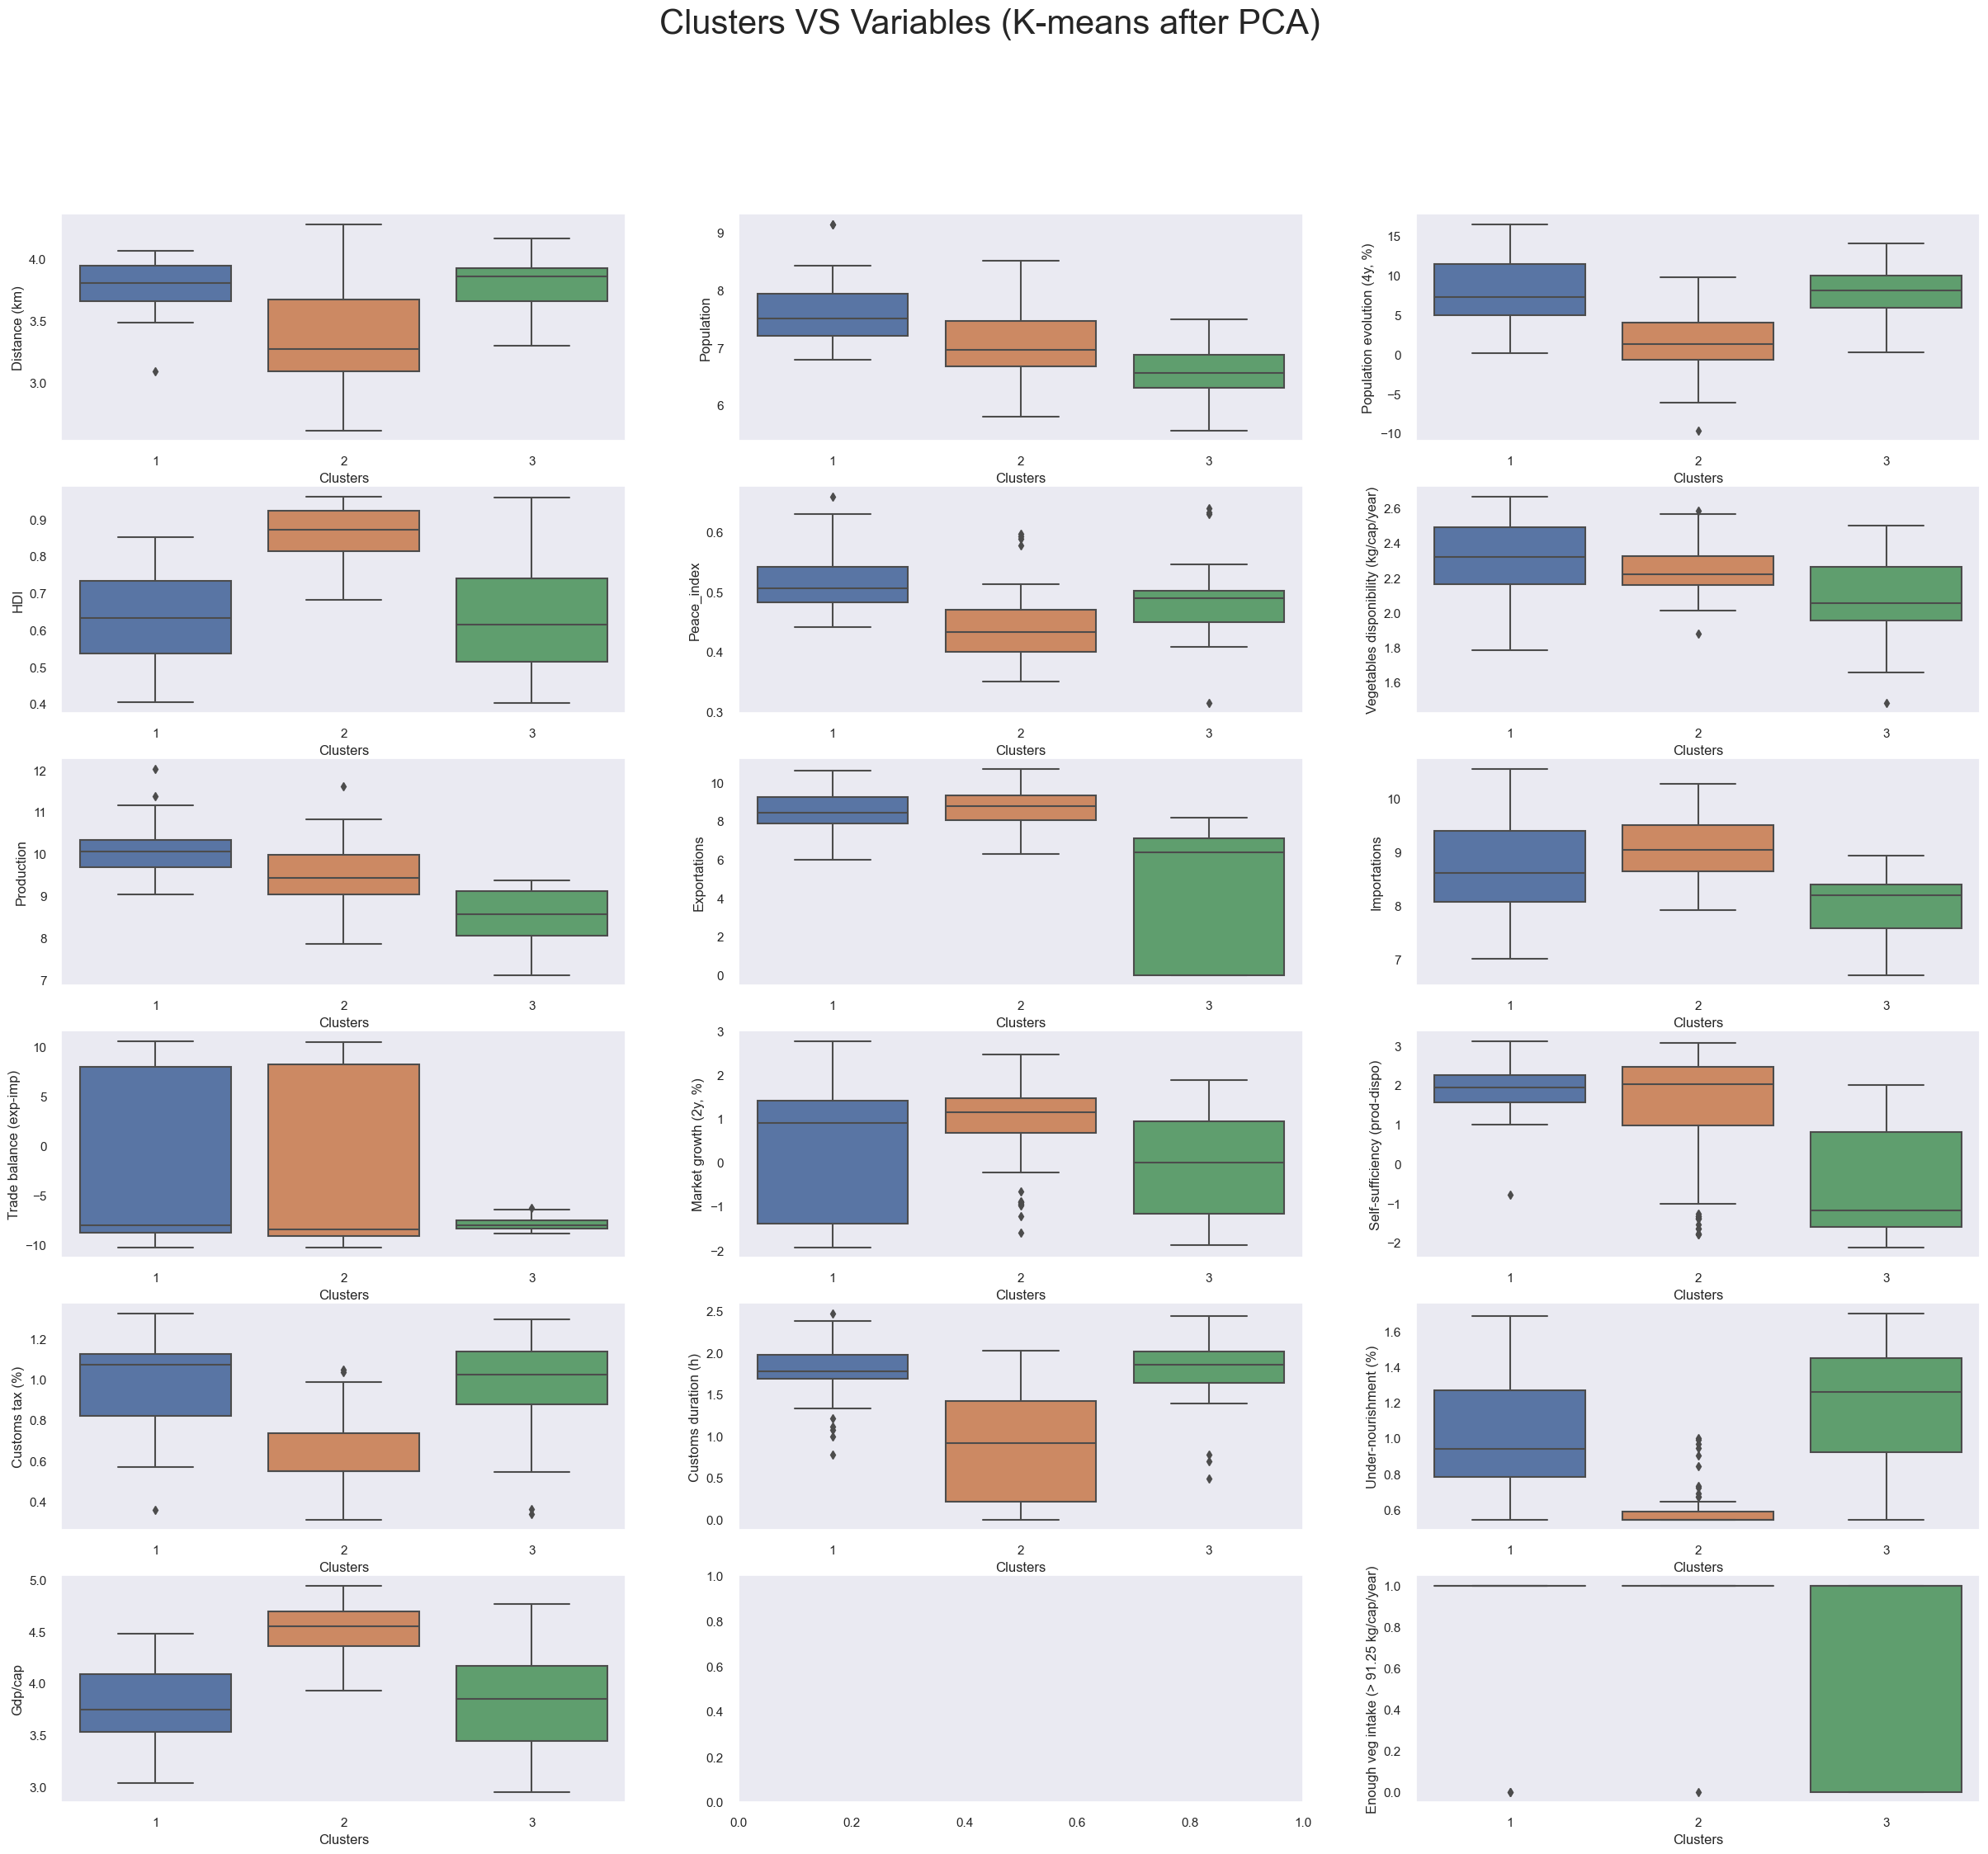

In [56]:
# visualisation boxplots des caractéristiques de chaque cluster
plt.rcParams['axes.grid'] = False
fig, axes = plt.subplots(6, 3, figsize=(30, 25))

sns.set(font_scale=1.2)
data = p9_km_acp
x ='Clusters'

fig.suptitle('Clusters VS Variables (K-means after PCA)', size=30)
#plt.xticks(size=20)
#plt.yticks(size=20)
sns.boxplot(ax=axes[0, 0], data=p9_km_acp, x='Clusters', y="Distance (km)")
sns.boxplot(ax=axes[0, 1], data=p9_km_acp, x='Clusters', y="Population")
sns.boxplot(ax=axes[0, 2], data=p9_km_acp, x='Clusters', y='Population evolution (4y, %)')
sns.boxplot(ax=axes[1, 0], data=p9_km_acp, x='Clusters', y='HDI')
sns.boxplot(ax=axes[1, 1], data=p9_km_acp, x='Clusters', y='Peace_index')
sns.boxplot(ax=axes[1, 2], data=p9_km_acp, x='Clusters', y='Vegetables disponibility (kg/cap/year)')
sns.boxplot(ax=axes[2, 0], data=p9_km_acp, x='Clusters', y='Production')
sns.boxplot(ax=axes[2, 1], data=p9_km_acp, x='Clusters', y='Exportations')
sns.boxplot(ax=axes[2, 2], data=p9_km_acp, x='Clusters', y='Importations')
sns.boxplot(ax=axes[3, 0], data=p9_km_acp, x='Clusters', y='Trade balance (exp-imp)')
sns.boxplot(ax=axes[3, 1], data=p9_km_acp, x='Clusters', y='Market growth (2y, %)')
sns.boxplot(ax=axes[3, 2], data=p9_km_acp, x='Clusters', y='Self-sufficiency (prod-dispo)')
sns.boxplot(ax=axes[4, 0], data=p9_km_acp, x='Clusters', y='Customs tax (%)')
sns.boxplot(ax=axes[4, 1], data=p9_km_acp, x='Clusters', y='Customs duration (h)')
sns.boxplot(ax=axes[4, 2], data=p9_km_acp, x='Clusters', y='Under-nourishment (%)')
sns.boxplot(ax=axes[5, 0], data=p9_km_acp, x='Clusters', y='Gdp/cap')
sns.boxplot(ax=axes[5, 2], data=p9_km_acp, x='Clusters', y='Enough veg intake (> 91.25 kg/cap/year)');

**=> Cluster 1 :**
+ Distance France faible
+ Evolution population faible
+ IDH élevé
+ Stabilité politique élevée
+ Disponibilité intérieure moyenne
+ Production élevée
+ Exportation élevée
+ Importation élevée
+ Croissance marché moyenne
+ Distance des pays fournisseurs faible
+ Sous-alim faible
+ PIB/hab élevé
    
<span style="color:red">**==> Pays développés, proches de la France, avec production, exportations et importations élevées, moyen potentiel de croissance du marché**</span>
    
**=> Cluster 2 :**
+ Distance France élevée
+ Faible population
+ IDH moyen
+ Stabilité politique élevée
+ Disponibilité intérieure faible
+ Production faible à moyenne
+ Exportation faible
+ Importation élevée
+ Balance commerciale faible
+ Distance des pays fournisseurs élevée
+ Croissance marché moyen à élevée
+ Frais de douane faibles
+ Sous-alim faible à élevée
+ PIB/hab moyen

<span style="color:red">**==> Pays moyennement développés, très éloignés de la France et avec faible population (ce qui engendre des frais logistiques supplémentaires) MAIS avec une stabilité politique élevée, une disponibilité intérieure, production et exportations faibles, importations élevées, à moyen potentiel de croissance du marché et avec frais de douane faibles (ce qui peut contrebalancer les frais logistiques supplémentaires), pays ayant l'habitude d'avoir des fournisseurs très éloignés**</span>
        
**=> Cluster 3 :**
+ Distance France élevée
+ Evolution population élevée
+ IDH faible
+ Stabilité politique faible
+ Disponibilité intérieure faible
+ Production élevée
+ Exportation faible
+ Importation faible à élevée
+ Balance commerciale faible à moyenne
+ Distance des pays fournisseurs élevée
+ Croissance marché faible à élevée
+ Frais de douane élevés
+ Sous-alim élevée
+ PIB/hab faible

<span style="color:red">**==> Pays sous-développés, très éloignés de la France et ayant une forte évolution de la population, avec une stabilité politique faible, une disponibilité intérieure basse mais production élevée, exportations et importations faibles, il y a un potentiel de croissance du marché mais frais de douane très élevés, pays ayant l'habitude d'avoir des fournisseurs très éloignés**</span>

**=> Cluster 4 :**
+ Distance France élevée
+ Population élevée
+ Evolution population moyenne
+ IDH moyen
+ Stabilité politique moyenne à élevée
+ Disponibilité intérieure élevée
+ Production élevée
+ Exportation élevée
+ Importation élevée
+ Balance commerciale faible à élevée
+ Distance des pays fournisseurs élevée
+ Croissance marché faible à élevée
+ Frais de douane faibles à moyens
+ Sous-alim faible à moyen
+ PIB/hab moyen

<span style="color:red">**==> Pays moyennement développés ayant une forte population, très éloignés de la France et avec une stabilité politique moyenne, une disponibilité intérieure, production, exportations et importations élevées, il y a un potentiel de croissance du marché, frais de douane faibles à moyens, pays ayant l'habitude d'avoir des fournisseurs très éloignés**</span>

***D'après les analyses des clusters du K-Means, le plus approprié s'avère le Cluster 2, à voir le 1 également***

### Heatmaps 

In [57]:
# pour une future visualisation on détermine les labels pour illustrer les clusters sur projection ACP
lab_km = p9_km_acp.copy()
lab_km['Clusters_name'] = lab_km['Clusters'].map({1: 'Plus gros producteurs, haute disponibilité, faible croissance du marché', 
                                                         2: 'Pays les plus riches, bonne disponibilité', 
                                                         3: 'Pays les plus pauvres, instables politiquement, moyennes importations, taxes élevées', 
                                                         4: 'Faible production, importations élevées, haute stabilité politique, taxes basses'})
#lab_km.head()

In [58]:
# caractéristiques moyennes par cluster
p9_km_acp = p9_km_acp.groupby(by='Clusters').mean()
p9_km_acp

Population  Under-nourishment (%)  HDI  Peace_index  \
Clusters                                                        
1               7.58                   1.00 0.64         0.51   
2               7.02                   0.60 0.87         0.44   
3               6.58                   1.18 0.64         0.49   

          Vegetables disponibility (kg/cap/year)  \
Clusters                                           
1                                           2.32   
2                                           2.26   
3                                           2.08   

          Enough veg intake (> 91.25 kg/cap/year)  Production  Exportations  \
Clusters                                                                      
1                                            0.96       10.11          8.47   
2                                            0.98        9.50          8.72   
3                                            0.70        8.53          4.39   

          Importations  Customs duration (h)  Customs tax (%)  Distance (km)  \
Clusters                                                                       
1                 8.70                  1.77             0.98           3.79   
2                 9.10                  0.87             0.63           3.36   
3                 7.98                  1.75             0.98           3.79   

          Gdp/cap  Population evolution (4y, %)  Trade balance (exp-imp)  \
Clusters                                                                   
1            3.77                          8.19                    -2.34   
2            4.51                          1.51                    -3.64   
3            3.84                          7.71                    -7.93   

          Self-sufficiency (prod-dispo)  Market growth (2y, %)  
Clusters                                                        
1                                  1.92                   0.27  
2                                  1.37                   0.87  
3                                 -0.55                  -0.09

In [59]:
# les données sont centrées et réduites pour mettre à la même échelle les variables au sein des clusters
scaler = preprocessing.StandardScaler()

km_sc = scaler.fit_transform(p9_km_acp)
km_sc = pd.DataFrame(km_sc, index=p9_km_acp.index, columns=p9_km_acp.columns).T
km_sc

Clusters                                    1     2     3
Population                               1.27 -0.10 -1.17
Under-nourishment (%)                    0.31 -1.35  1.04
HDI                                     -0.71  1.41 -0.70
Peace_index                              1.08 -1.33  0.24
Vegetables disponibility (kg/cap/year)   1.00  0.37 -1.37
Enough veg intake (> 91.25 kg/cap/year)  0.63  0.78 -1.41
Production                               1.12  0.18 -1.31
Exportations                             0.64  0.77 -1.41
Importations                             0.22  1.10 -1.32
Customs duration (h)                     0.72 -1.41  0.69
Customs tax (%)                          0.72 -1.41  0.69
Distance (km)                            0.72 -1.41  0.70
Gdp/cap                                 -0.81  1.41 -0.60
Population evolution (4y, %)             0.78 -1.41  0.63
Trade balance (exp-imp)                  0.96  0.42 -1.38
Self-sufficiency (prod-dispo)            0.95  0.43 -1.38
Market growth (2y, %)                   -0.20  1.31 -1.11

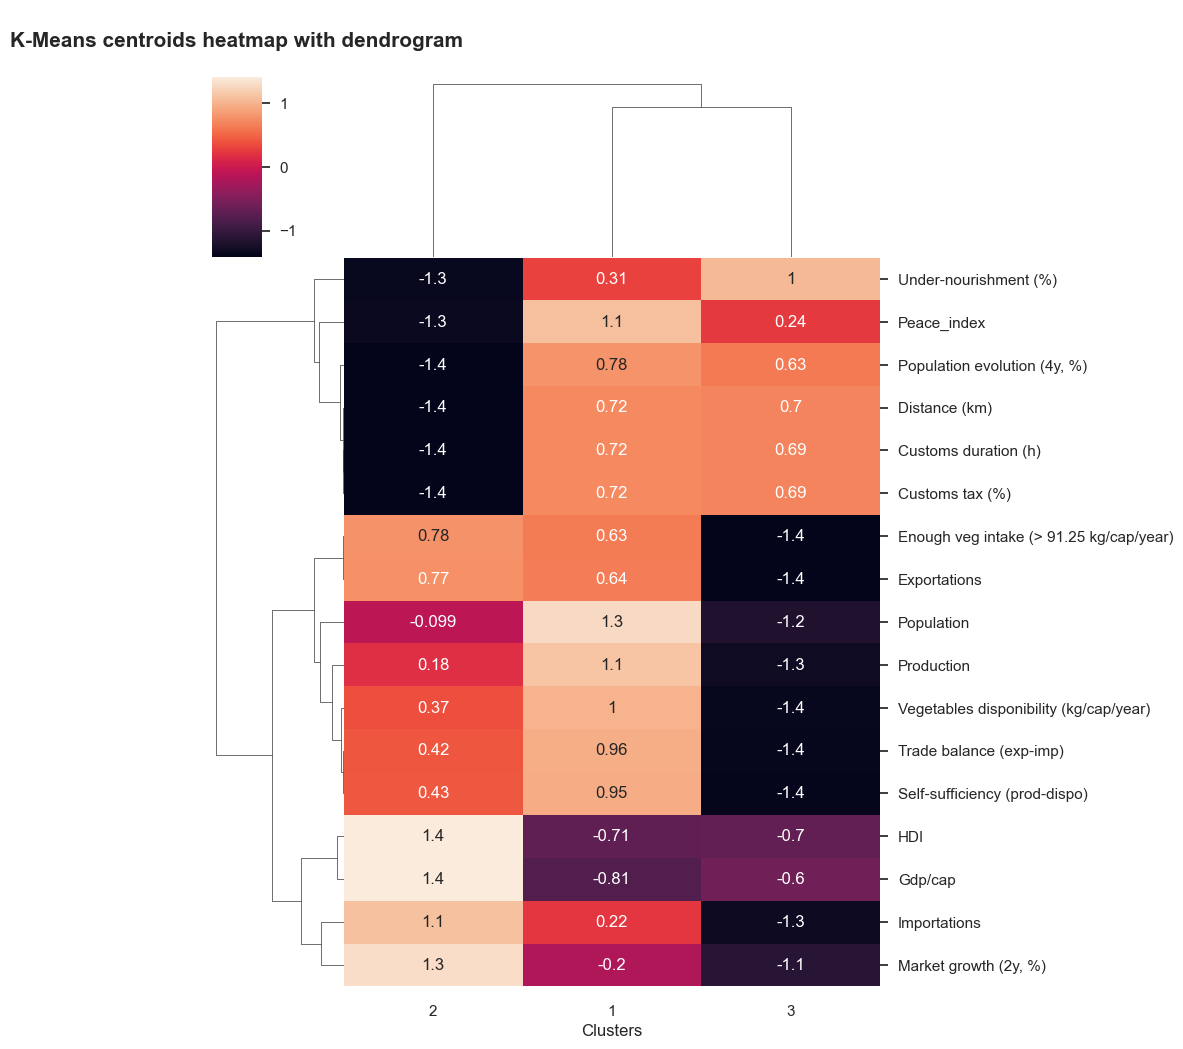

In [60]:
# visualisation heatmap avec dendrogramme
#fig = plt.figure(figsize=(15,12))
sns.set(font_scale=1)
sns.clustermap(km_sc, annot=True)
plt.title('\nK-Means centroids heatmap with dendrogram\n', fontsize=15, fontweight='bold')
plt.savefig('img/saved/km_heatmap.jpeg');

### Radar chart

In [61]:
#km_sc.index

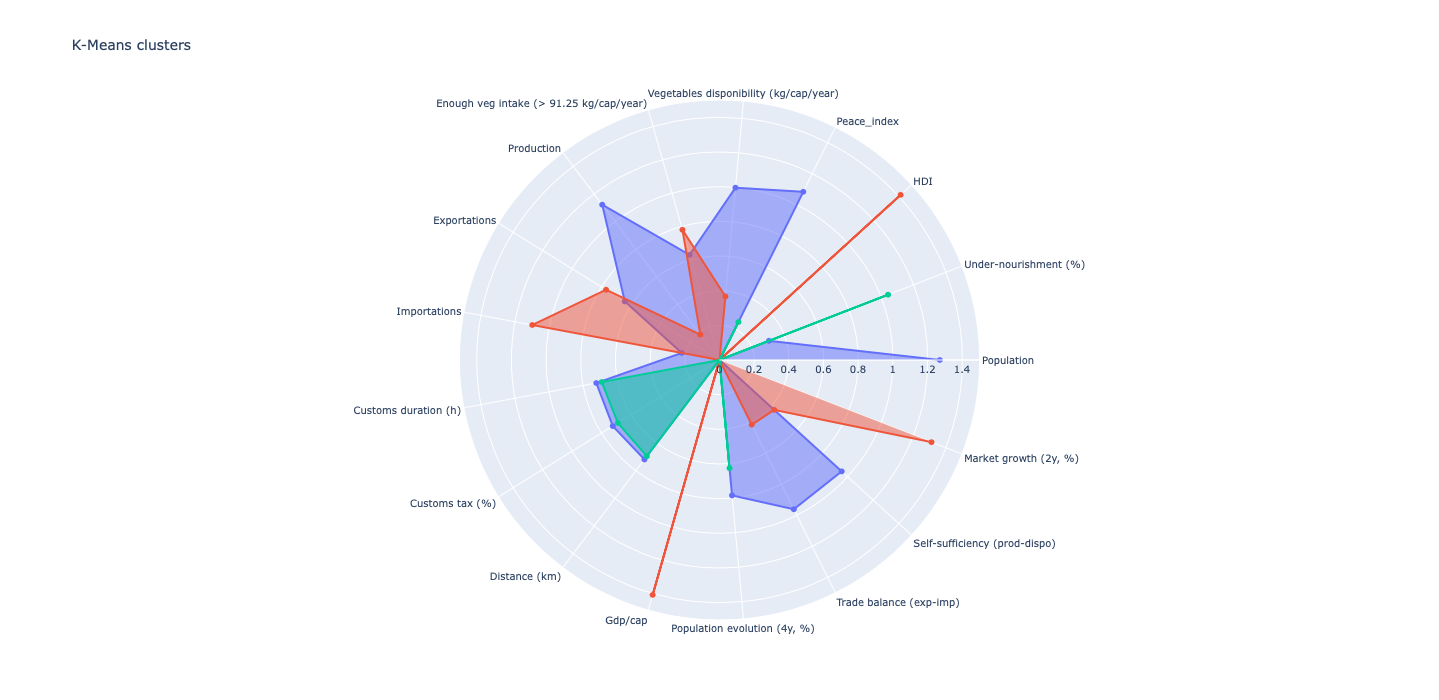

<Figure size 2000x2000 with 0 Axes>

In [62]:
# visualisation radar chart
categories = ['Population', 'Under-nourishment (%)', 'HDI', 'Peace_index',
       'Vegetables disponibility (kg/cap/year)',
       'Enough veg intake (> 91.25 kg/cap/year)', 'Production', 'Exportations',
       'Importations', 'Customs duration (h)', 'Customs tax (%)',
       'Distance (km)', 'Gdp/cap', 'Population evolution (4y, %)',
       'Trade balance (exp-imp)', 'Self-sufficiency (prod-dispo)', 'Market growth (2y, %)']

fig = plt.figure(figsize=(20,20))
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=km_sc[1],
      theta=categories,
      fill='toself',
      name='C1'
))

fig.add_trace(go.Scatterpolar(
      r=km_sc[2],
      theta=categories,
      fill='toself',
      name='C2'
))

fig.add_trace(go.Scatterpolar(
      r=km_sc[3],
      theta=categories,
      fill='toself',
      name='C3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1.5]
    )),
  showlegend=False
)

fig.update_layout(title_text="K-Means clusters", font_size=10, width=800, height=700)
fig.show()

### Clusters' projection on PCA F1-F4 components

Populating the interactive namespace from numpy and matplotlib


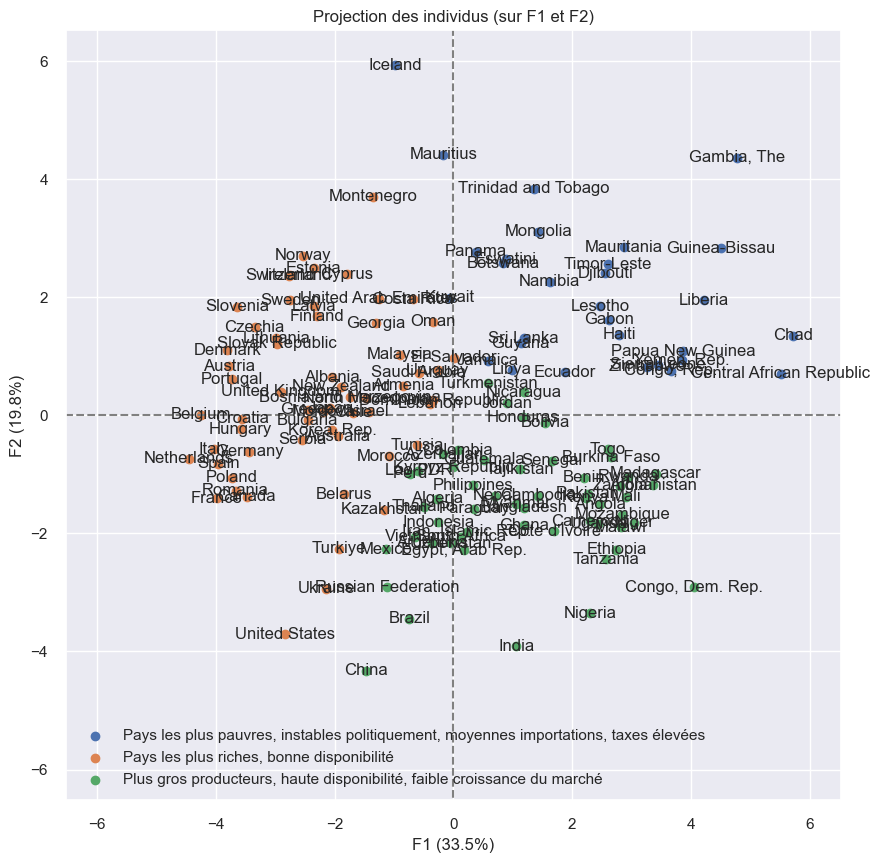

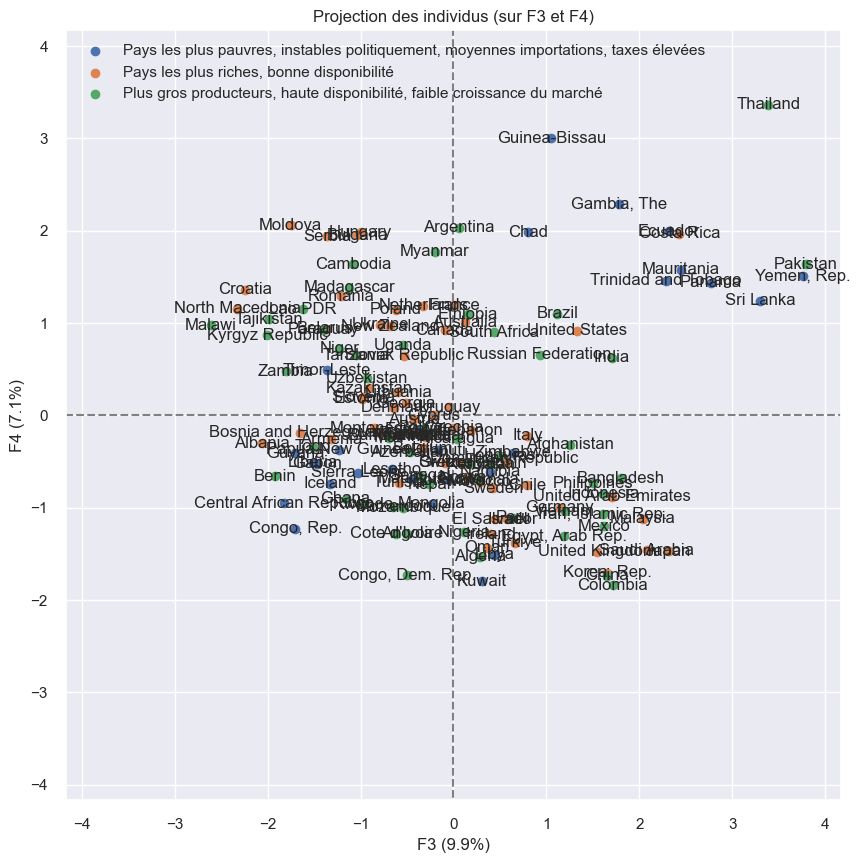

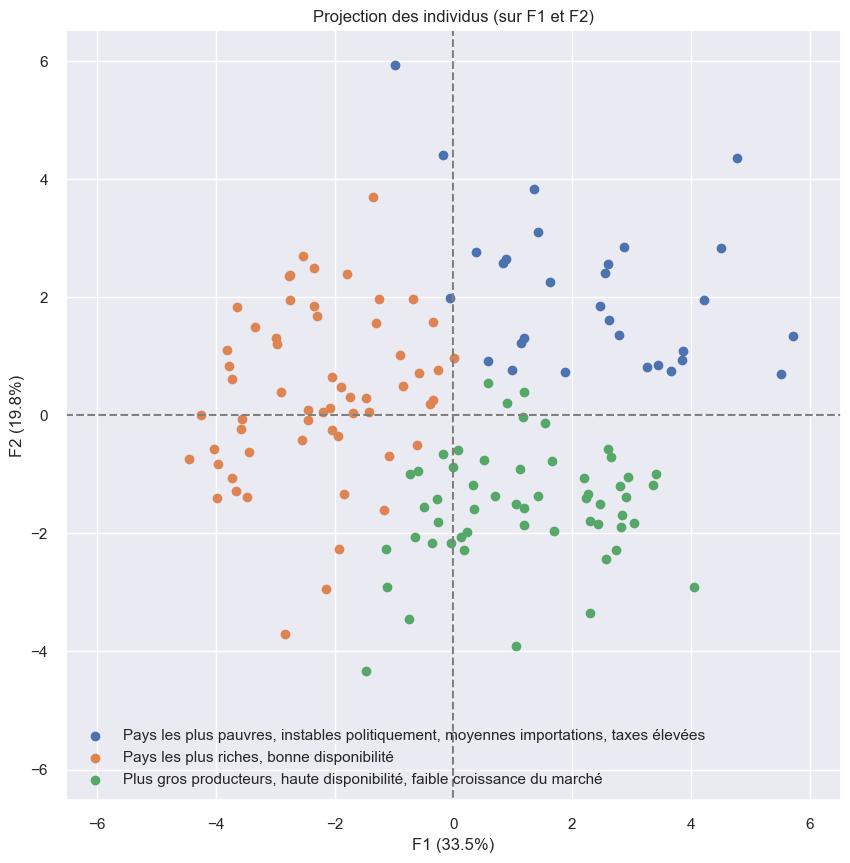

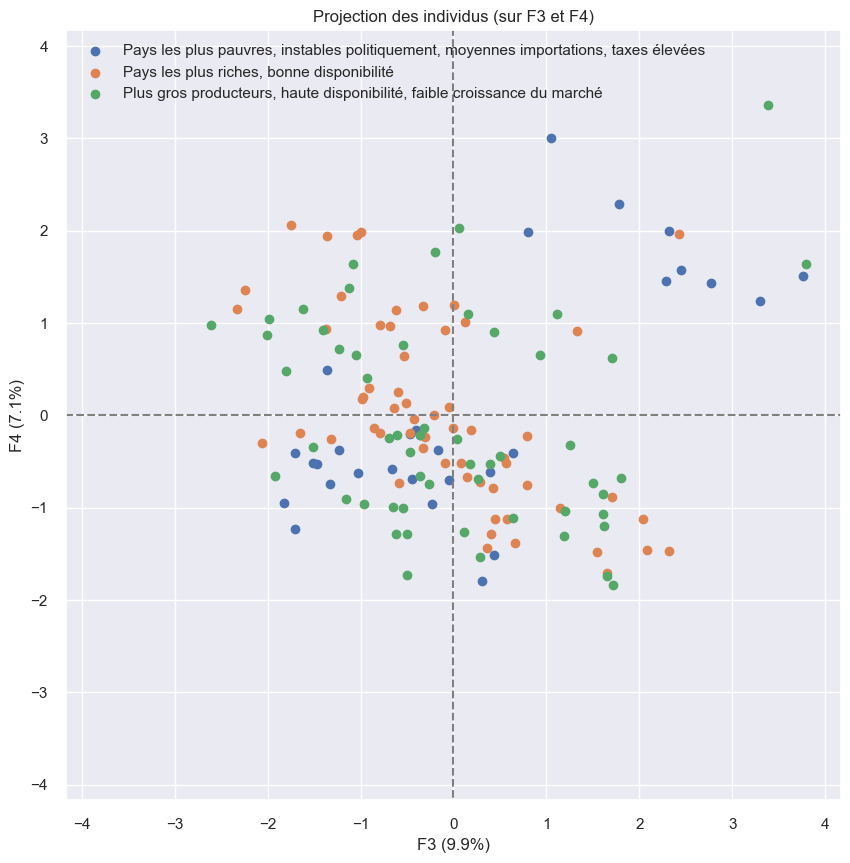

In [63]:
# visualisation projection des individus et clusters
%pylab inline

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], 
                         illustrative_var = lab_km.Clusters_name, 
                         labels = np.array(names))
plt.show()

#Projection des individus sans noms des pays
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], 
                         illustrative_var = lab_km.Clusters_name, 
                         labels = None)
plt.show()

# Projection des centroïdes
#df2 = p9_log.groupby('Clusters').mean().reset_index()
#df2 = df2.drop(columns='Clusters')
#X = df2.values
#std_scale = preprocessing.StandardScaler().fit(X)
#X_scaled = std_scale.transform(X)
#X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var=df2.index)
#plt.show()

## t-SNE

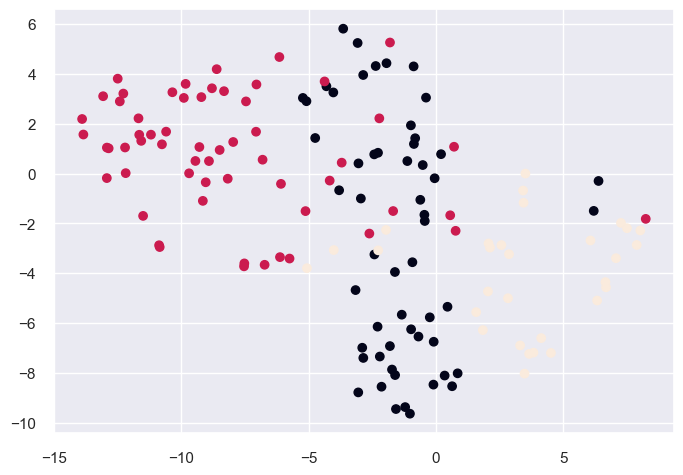

In [64]:
# visualisation
# create a TSNE instance: model
model = TSNE(learning_rate=300)

# apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(X_scaled)

# select the 0th feature: xs
xs = tsne_features[:,0]

# select the 1st feature: ys
ys = tsne_features[:,1]

# scatter plot, coloring by variety_numbers
plt.scatter(xs, ys, c=clusters)
plt.show()

# Countries choice

<span style="color:red">**=> Au vu des résultats des clusterings CAH et K-Means le choix le plus approprié est :**</span>
+ Cluster 2 du CAH ou 
+ Cluster 4 du K-Means

*Ce sont les pays moyennement développés à développés, éloignés de la France et avec une faible population (ce qui engendre des frais logistiques supplémentaires) MAIS avec une stabilité politique élevée, une disponibilité intérieure, production et exportations faibles, importations élevées, à moyen potentiel de croissance du marché et avec frais de douane faibles (ce qui peut contrebalancer les frais logistiques supplémentaires), pays ayant l'habitude d'avoir des fournisseurs éloignés.*

***Pour choisir entre le Cluster 2 CAH et le Cluster 4 K-Means nous allons les comparer ci-dessous :***

In [65]:
df1 = c2_cah_acp[~c2_cah_acp.isin(c4_km_acp)].dropna()
df2 = c4_km_acp[~c4_km_acp.isin(c2_cah_acp)].dropna()

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Pays du Cluster 2 CAH absent du Cluster 4 K-Means').set_table_styles(styles)
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Pays du Cluster 4 K-means absent du Cluster 2 CAH').set_table_styles(styles)

space = "\xa0" * 10
display_html(df1_styler._repr_html_() + space + df2_styler._repr_html_(), raw=True)

NameError: name 'c4_km_acp' is not defined

***On remarque que le Cluster 4 K-Means comporte un pays en plus (Laos) et que le Cluster 2 CAH comporte 13 pays en plus, dont certains en Europe.***

*Les pays étant distribués de manière plus équilibrée à travers les différents continents tout en répondant aux mêmes caractéristiques d'une faible disponibilité intérieure et production, de taux de douanes faibles ainsi que d'importations continues et soutenues, le tout dans un cadre d'une stabilité politique élevée, le cluster 2 CAH permet une meilleure stratégie de diversification mondiale.*

<span style="color:red">**==> Le choix final se portera donc sur le Cluster 2 CAH**</span>

In [ ]:
choix_pays = c2_cah_acp
choix_pays.style.set_table_attributes("style='display:inline'").set_caption('Choix final des pays').set_table_styles(styles)

In [ ]:
iso_cah = p9.merge(choix_pays, how='inner', on='Pays')
iso_cah = iso_cah[['ISO', 'Pays']]
iso_cah.sample()

In [ ]:
fig = px.choropleth(iso_cah, locations="ISO",
              hover_name="Pays", 
              projection="natural earth",
              title="53 pays potentiels" 
              )
fig.update_layout(title_x=0.5, title_y=0.89)
#fig.update_layout(coloraxis_colorbar_title='')
fig.update_coloraxes(showscale=False)
fig.update_layout(width=900, height=600)
fig.add_layout_image(dict(
        xref="paper", yref="paper",
        x=0.65, y=1.15,
        sizex=0.3, sizey=0.3,
        xanchor="right", yanchor="bottom"))